In [ ]:
!pip install yfinance pmdarima statsmodels arch ta

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 22.8 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=23eac6d3220ec2ff0f3eda6dcbb15ddf87bceb28c3bb3d7d3444fe20c5e04aab
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


# 1. PACKAGE IMPORTING AND DATA COLLECTION


## 1.1 Import dependencies

In [ ]:
# Standard library imports
import os
import sys
import math
import warnings
import itertools
from math import sqrt
from datetime import datetime
from itertools import product
from datetime import datetime, timedelta

# Third-party library imports
from arch import arch_model
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pmdarima import auto_arima
from pandas.plotting import lag_plot
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.models import Sequential

# IPython display
from IPython.display import Image, display, HTML

In [ ]:
warnings.filterwarnings("ignore")
# Use a consistent style
plt.style.use('seaborn')

## 1.2  Download Data and tickers

In [ ]:
# Download data
TICKER = "TSLA"
target_column = 'Close'
df = yf.download(TICKER, start="2018-01-01", end="2024-01-01").reset_index()
# df = pd.read_csv('TSLA.csv')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training and test sets
split_date = df.index[int(len(df) * 0.8)]
train = df[:split_date]
test = df[split_date:]

## 1.3 Exploratory Data Analysis

In [ ]:
df[['Open', 'High',	'Low',	'Close',	'Adj Close',	'Volume']].describe()

Open         High          Low        Close    Adj Close  \
count  1509.000000  1509.000000  1509.000000  1509.000000  1509.000000   
mean    146.023254   149.313587   142.479038   145.981504   145.981504   
std     113.661210   116.141645   110.885498   113.530192   113.530192   
min      12.073333    12.445333    11.799333    11.931333    11.931333   
25%      22.250000    22.660000    21.833332    22.271334    22.271334   
50%     159.663330   161.619995   153.279999   160.190002   160.190002   
75%     241.770004   246.990005   236.976669   242.190002   242.190002   
max     411.470001   414.496674   405.666656   409.970001   409.970001   

             Volume  
count  1.509000e+03  
mean   1.332430e+08  
std    8.365567e+07  
min    2.940180e+07  
25%    8.112930e+07  
50%    1.090935e+08  
75%    1.550325e+08  
max    9.140820e+08

In [ ]:
df.dtypes

index          int64
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
# Check for missing values
df.isnull().sum()

index        0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
test.head()

index        Open        High         Low       Close   Adj Close  \
Date                                                                            
2022-10-18   1207  229.500000  229.820007  217.250000  220.190002  220.190002   
2022-10-19   1208  219.800003  222.929993  217.779999  222.039993  222.039993   
2022-10-20   1209  208.279999  215.550003  202.000000  207.279999  207.279999   
2022-10-21   1210  206.419998  214.660004  203.800003  214.440002  214.440002   
2022-10-24   1211  205.820007  213.500000  198.589996  211.250000  211.250000   

               Volume  
Date                   
2022-10-18   75891900  
2022-10-19   66571500  
2022-10-20  117798100  
2022-10-21   75713800  
2022-10-24  100446800

In [ ]:
train.head()

index       Open       High        Low      Close  Adj Close  \
Date                                                                       
2018-01-02      0  20.799999  21.474001  20.733334  21.368668  21.368668   
2018-01-03      1  21.400000  21.683332  21.036667  21.150000  21.150000   
2018-01-04      2  20.858000  21.236668  20.378668  20.974667  20.974667   
2018-01-05      3  21.108000  21.149332  20.799999  21.105333  21.105333   
2018-01-08      4  21.066668  22.468000  21.033333  22.427334  22.427334   

               Volume  
Date                   
2018-01-02   65283000  
2018-01-03   67822500  
2018-01-04  149194500  
2018-01-05   68868000  
2018-01-08  147891000

In [ ]:
def plot_open_vs_high(df):
    plt.figure(figsize=(10, 6))

    # Scatter plot with 'Date' on x-axis and 'Close' on y-axis
    plt.scatter(df.index, df['Close'], color='blue', edgecolor='black')

    # Set title and labels
    plt.title('Close Price vs Date')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    # Format the x-axis to show dates clearly
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

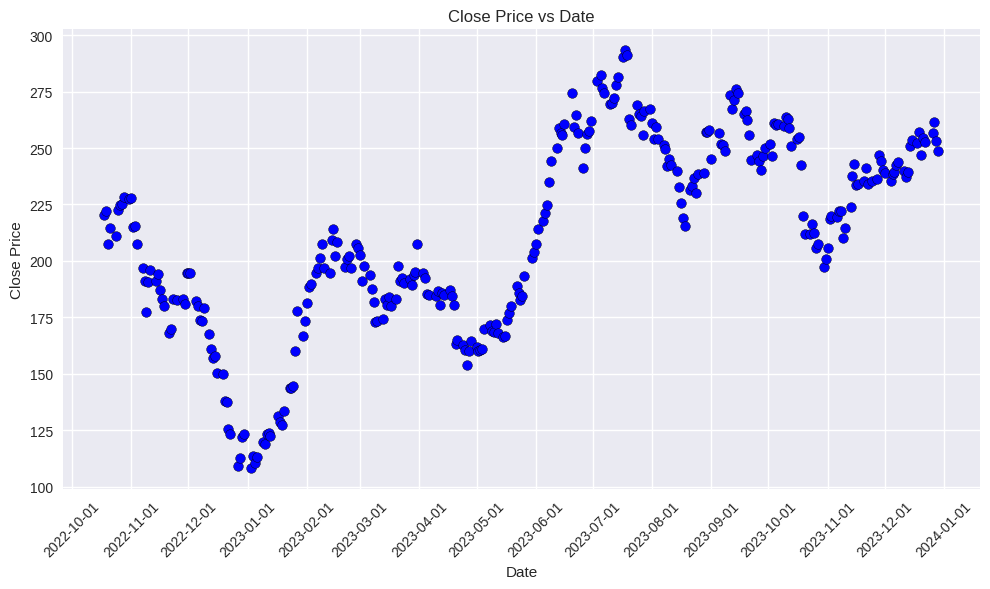

index        Open        High         Low       Close   Adj Close  \
Date                                                                            
2022-10-18   1207  229.500000  229.820007  217.250000  220.190002  220.190002   
2022-10-19   1208  219.800003  222.929993  217.779999  222.039993  222.039993   
2022-10-20   1209  208.279999  215.550003  202.000000  207.279999  207.279999   
2022-10-21   1210  206.419998  214.660004  203.800003  214.440002  214.440002   
2022-10-24   1211  205.820007  213.500000  198.589996  211.250000  211.250000   

               Volume  
Date                   
2022-10-18   75891900  
2022-10-19   66571500  
2022-10-20  117798100  
2022-10-21   75713800  
2022-10-24  100446800

In [ ]:
plot_open_vs_high(test)
test.head()

# 2. Feature Engineering

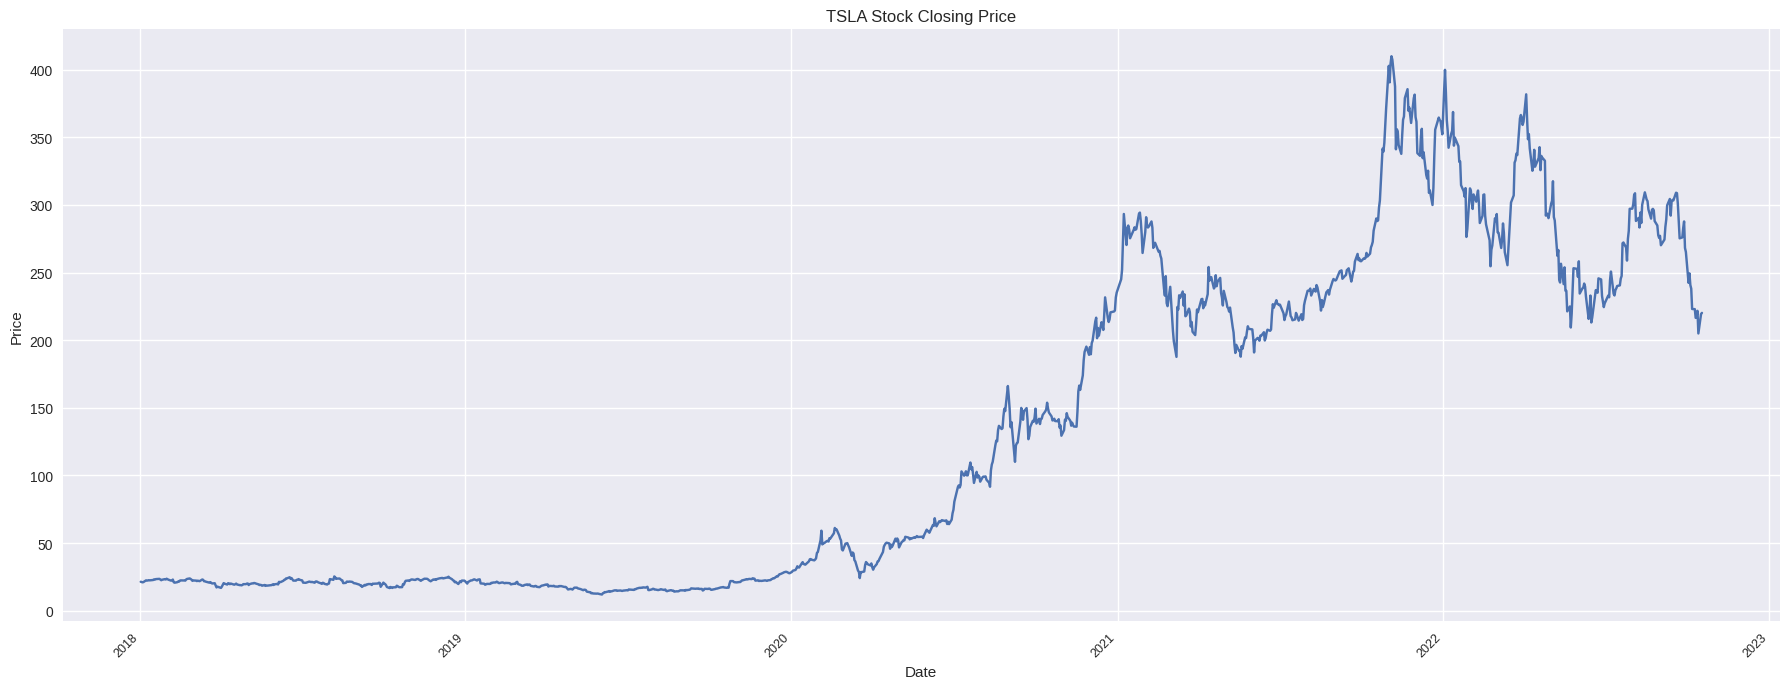

In [ ]:
# Plot the closing price
plt.figure(figsize=(18, 7))
plt.plot(train.index, train['Close'])
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

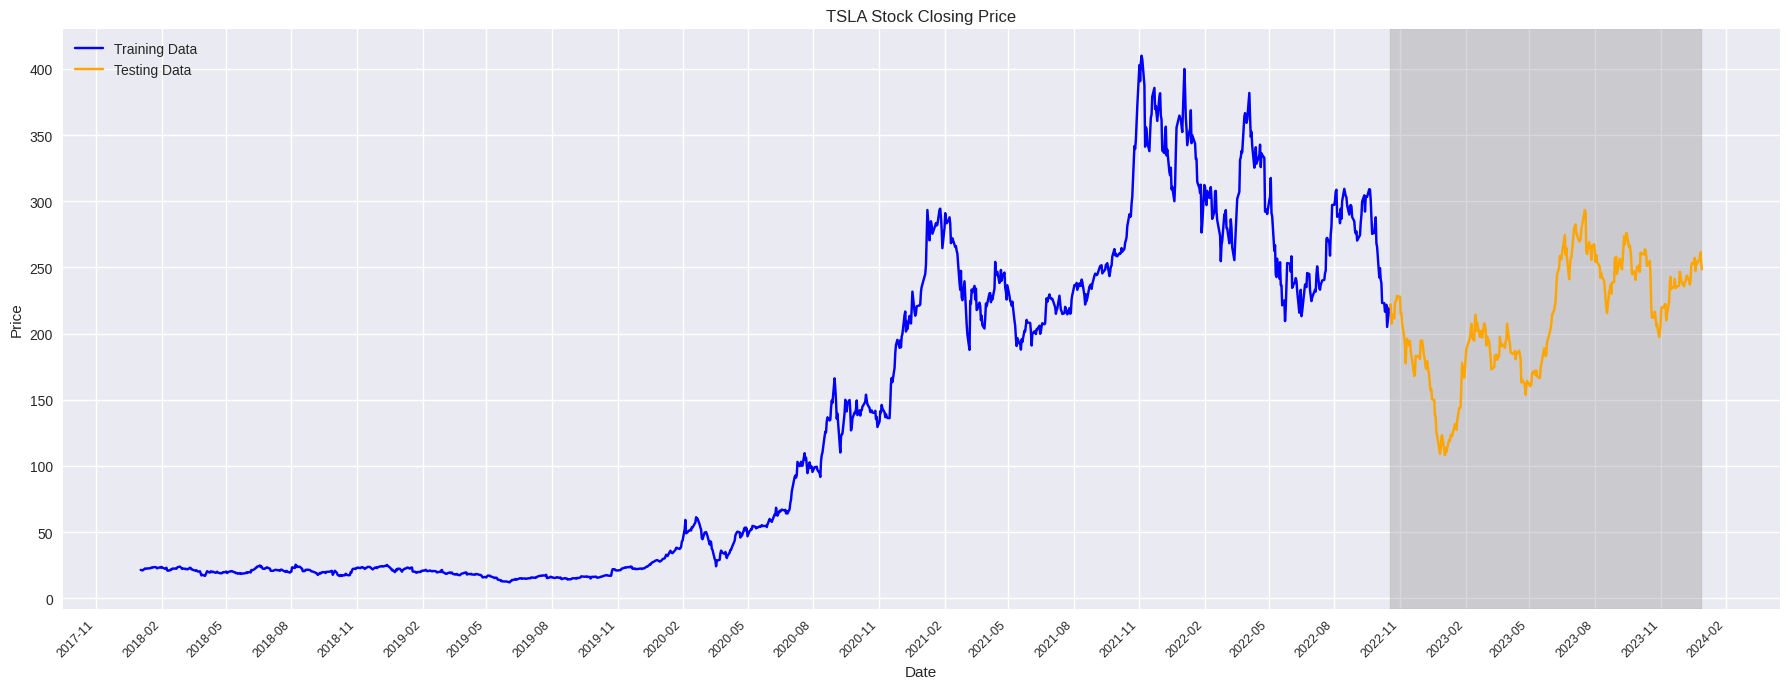

In [ ]:
# Plot the closing price with shading for the testing period
plt.figure(figsize=(18, 7))

# Plot the training data
plt.plot(train.index, train['Close'], label='Training Data', color='blue')

# Plot the testing data
plt.plot(test.index, test['Close'], label='Testing Data', color='orange')

# Shade the testing area
plt.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.3)

# Set the title and labels
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')

# Add grid and format the x-axis
plt.grid(True)
plt.xticks(rotation=45, ha='right', fontsize=9)

# Set major ticks to every 3 months and minor ticks to every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Add a legend
plt.legend()

# Adjust layout for better fit
plt.tight_layout()

# Display the plot
plt.show()


## 2.1 Add Extra Features

## 2.3 Plot Stock Analysis Charts

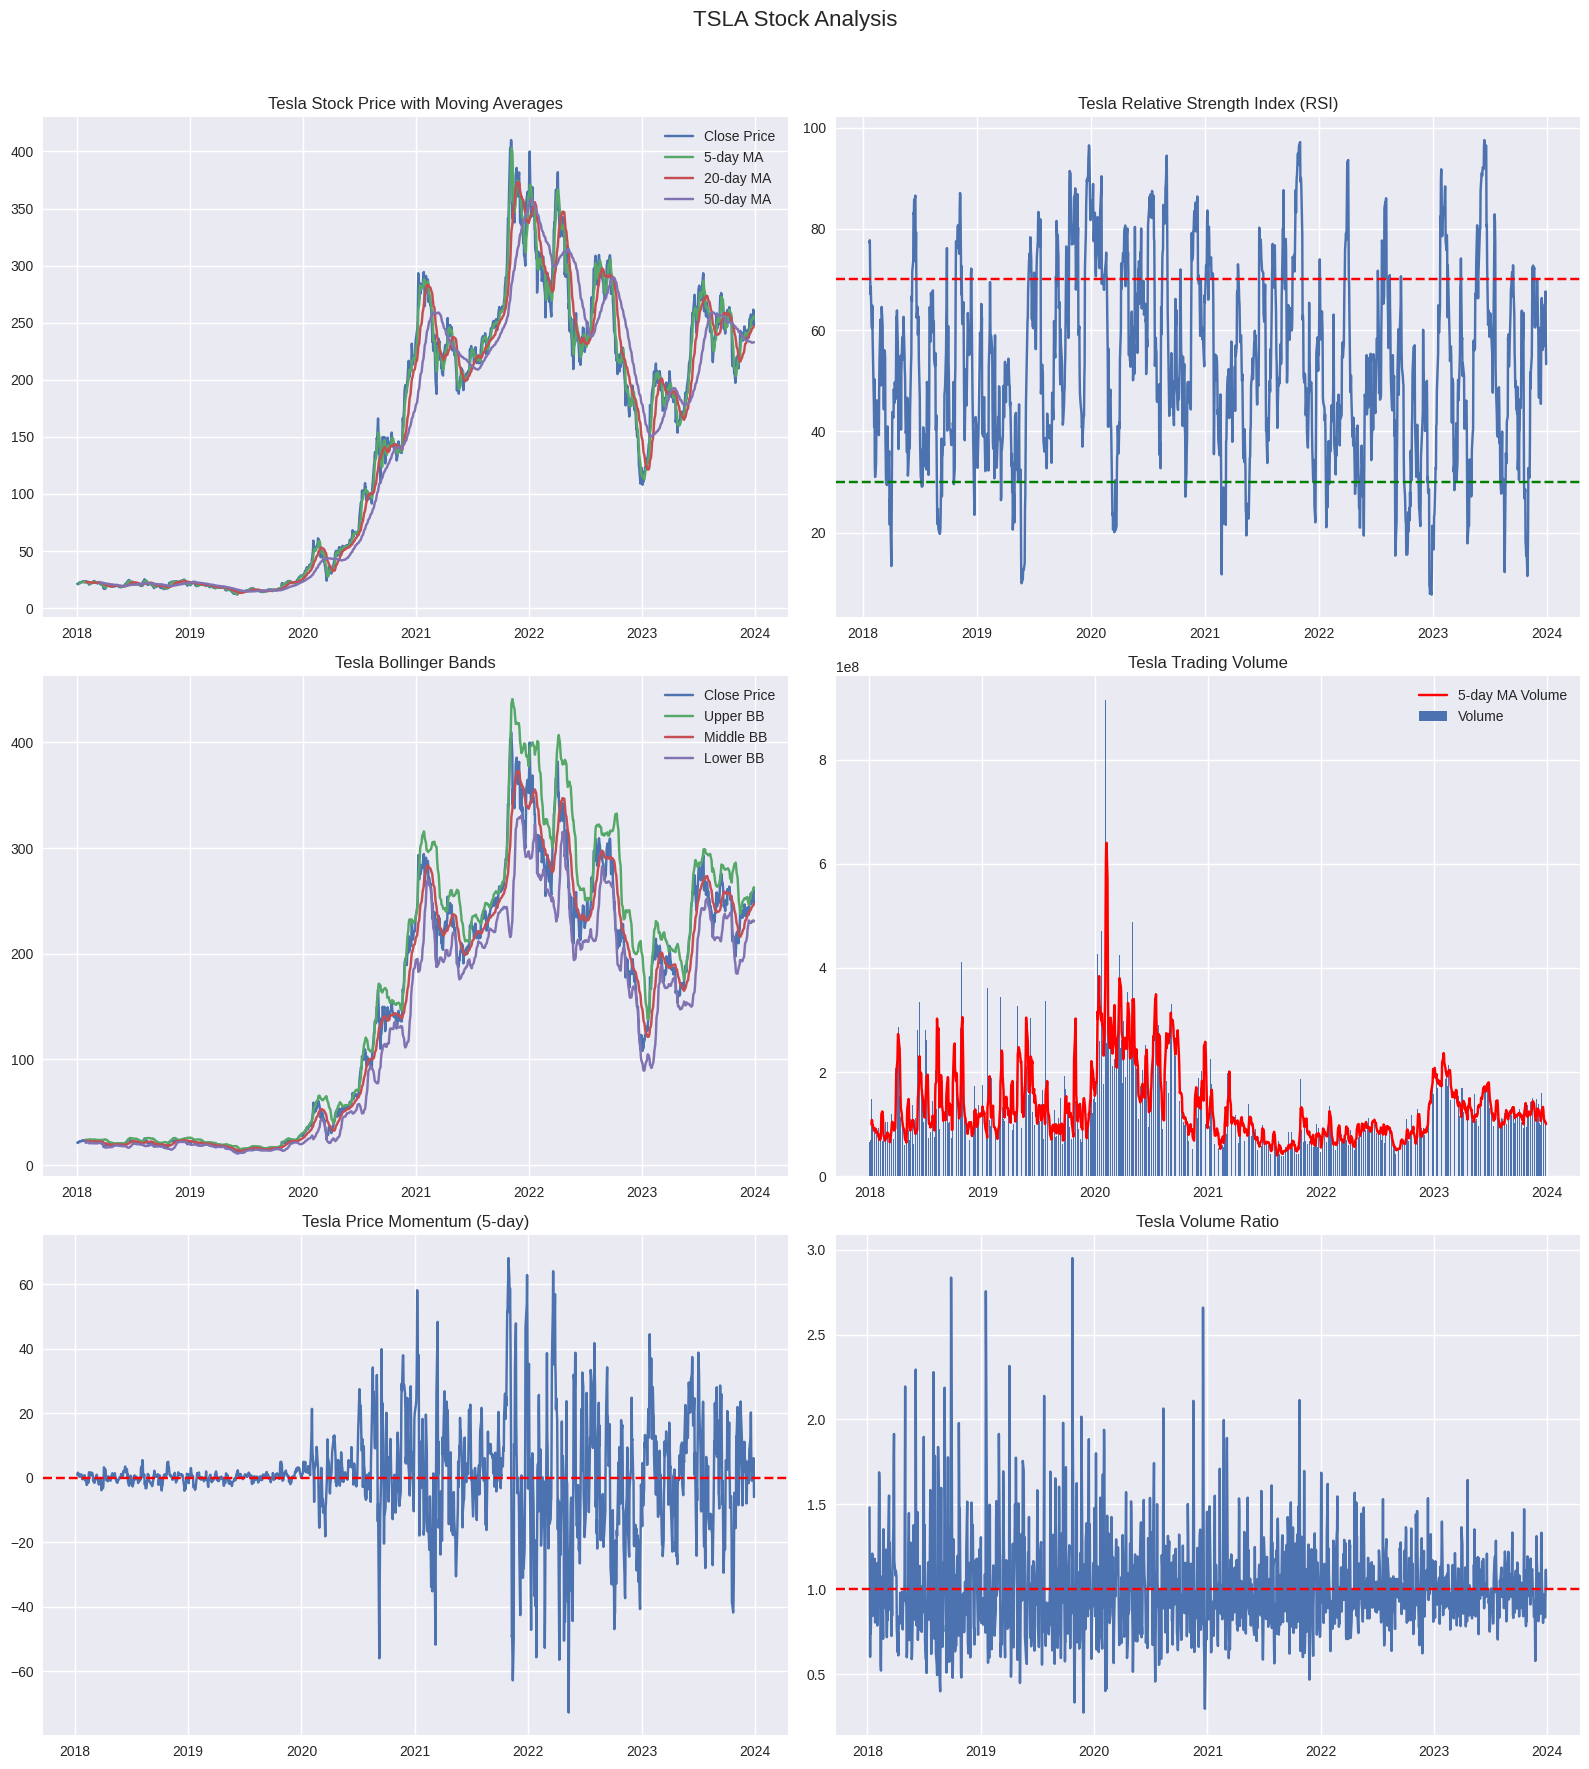

In [ ]:
# Calculate missing columns and add them to the DataFrame
# Moving Averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
std = df['Close'].rolling(window=20).std()
df['BB_middle'] = df['MA20']
df['BB_upper'] = df['BB_middle'] + (std * 2)
df['BB_lower'] = df['BB_middle'] - (std * 2)

# Volume Moving Average
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

# Price Momentum
df['Price_Momentum'] = df['Close'].diff(periods=5)

# Volume Ratio
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('TSLA Stock Analysis', fontsize=16)

# 1. Moving Averages
axs[0, 0].plot(df.index, df['Close'], label='Close Price')
axs[0, 0].plot(df.index, df['MA5'], label='5-day MA')
axs[0, 0].plot(df.index, df['MA20'], label='20-day MA')
axs[0, 0].plot(df.index, df['MA50'], label='50-day MA')
axs[0, 0].set_title('Tesla Stock Price with Moving Averages')
axs[0, 0].legend()

# 2. RSI
axs[0, 1].plot(df.index, df['RSI'], label='RSI')
axs[0, 1].set_title('Tesla Relative Strength Index (RSI)')
axs[0, 1].axhline(y=70, color='r', linestyle='--')
axs[0, 1].axhline(y=30, color='g', linestyle='--')

# 3. Bollinger Bands
axs[1, 0].plot(df.index, df['Close'], label='Close Price')
axs[1, 0].plot(df.index, df['BB_upper'], label='Upper BB')
axs[1, 0].plot(df.index, df['BB_middle'], label='Middle BB')
axs[1, 0].plot(df.index, df['BB_lower'], label='Lower BB')
axs[1, 0].set_title('Tesla Bollinger Bands')
axs[1, 0].legend()

# 4. Volume
axs[1, 1].bar(df.index, df['Volume'], label='Volume')
axs[1, 1].plot(df.index, df['Volume_MA5'], color='r', label='5-day MA Volume')
axs[1, 1].set_title('Tesla Trading Volume')
axs[1, 1].legend()

# 5. Price Momentum
axs[2, 0].plot(df.index, df['Price_Momentum'], label='Price Momentum')
axs[2, 0].set_title('Tesla Price Momentum (5-day)')
axs[2, 0].axhline(y=0, color='r', linestyle='--')

# 6. Volume Ratio
axs[2, 1].plot(df.index, df['Volume_Ratio'], label='Volume Ratio')
axs[2, 1].set_title('Tesla Volume Ratio')
axs[2, 1].axhline(y=1, color='r', linestyle='--')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
df.isnull().sum()

index                0
Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Daily_Return         1
Log_Return           1
Price_Range          0
Volume_Change        1
MA_10                9
MA_30               29
Volatility          20
RSI                 13
Daily_Pct_Change     1
MA5                  4
MA20                19
MA50                49
BB_middle           19
BB_upper            19
BB_lower            19
Volume_MA5           4
Price_Momentum       5
Volume_Ratio         4
dtype: int64

## 3.1 AutoCorrelation and Partial Correlation


>* Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

> * Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

### 3.1.1 ACF

Autocorrelation, sometimes known as serial correlation, is the correlation of a time series with a delayed copy of itself as a function of delay. That is, it measures the similarity between observations as a function of the time lag between them. The autocorrelation function can be used basically to detect non-randomness in data and identify cyclical patterns if present.

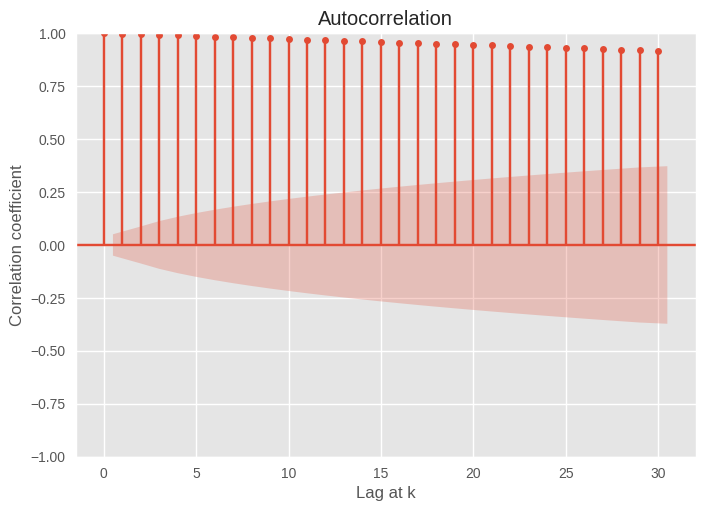

In [ ]:
plt.style.use('ggplot')
plot_acf(df['Close'], lags=30)
plt.ylabel("Correlation coefficient")
plt.xlabel('Lag at k')
plt.show()

### 3.1.2 PACF

The partial autocorrelation function of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.

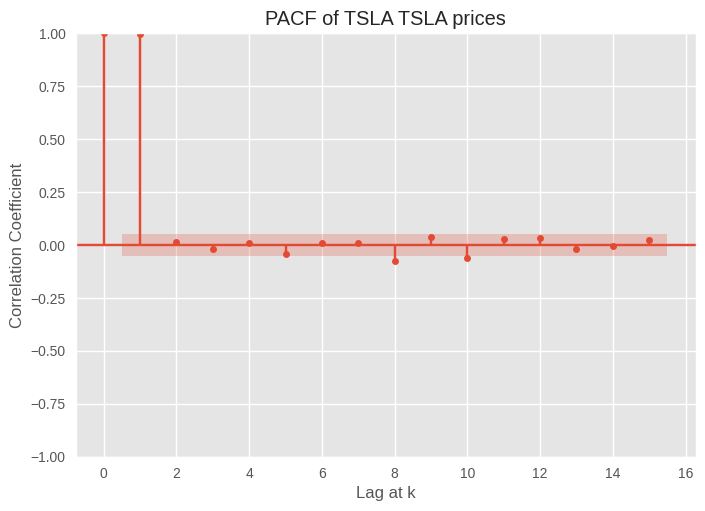

In [ ]:
plt.style.use('ggplot')
plot_pacf(df['Close'], lags=15)
plt.title(f"PACF of TSLA {TICKER} prices")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()

## 3.2 Stationarity
Most of the time series are non-stationary either it gives an upward or downward trend or seasonal effect. checking the stationarity is the most important thing that we should handle if we want to make a good prediction of such time serie.

#### 3.2.1 Graphical Analysis

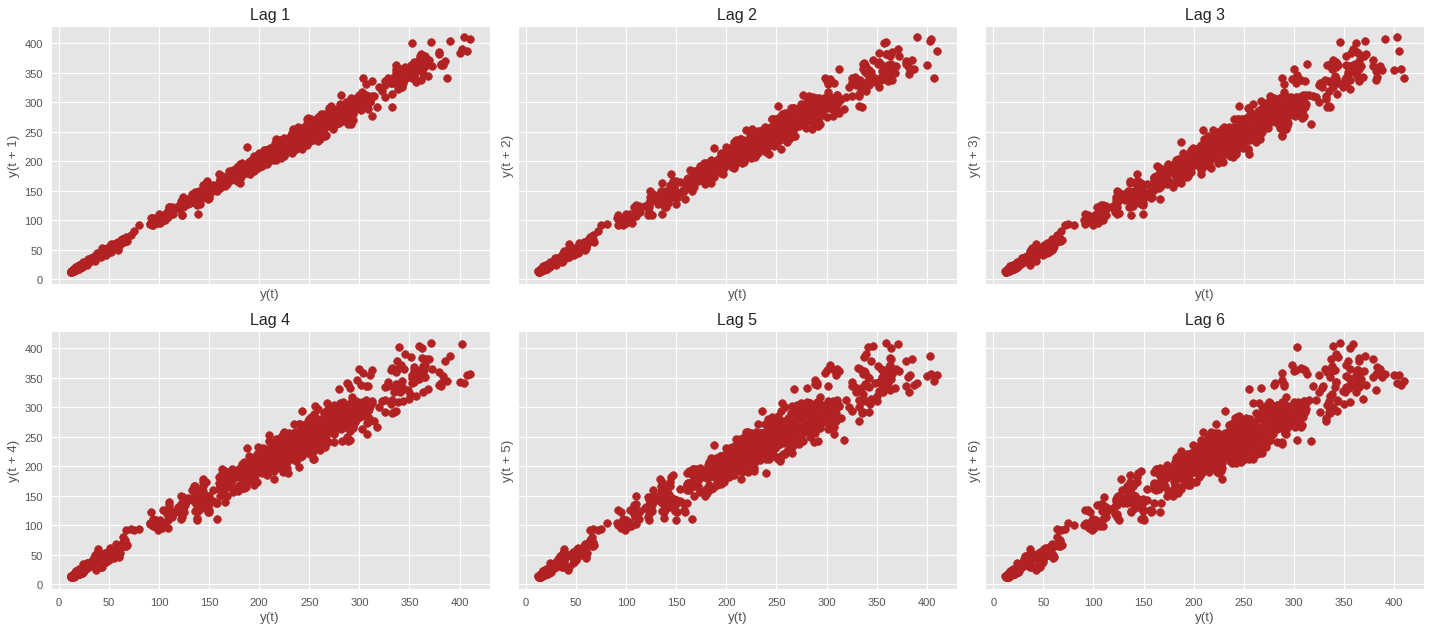

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True, dpi=80)
for i, ax in enumerate(axes.flatten()[:6]):
    lag_plot(df['Close'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.tight_layout()
plt.show()

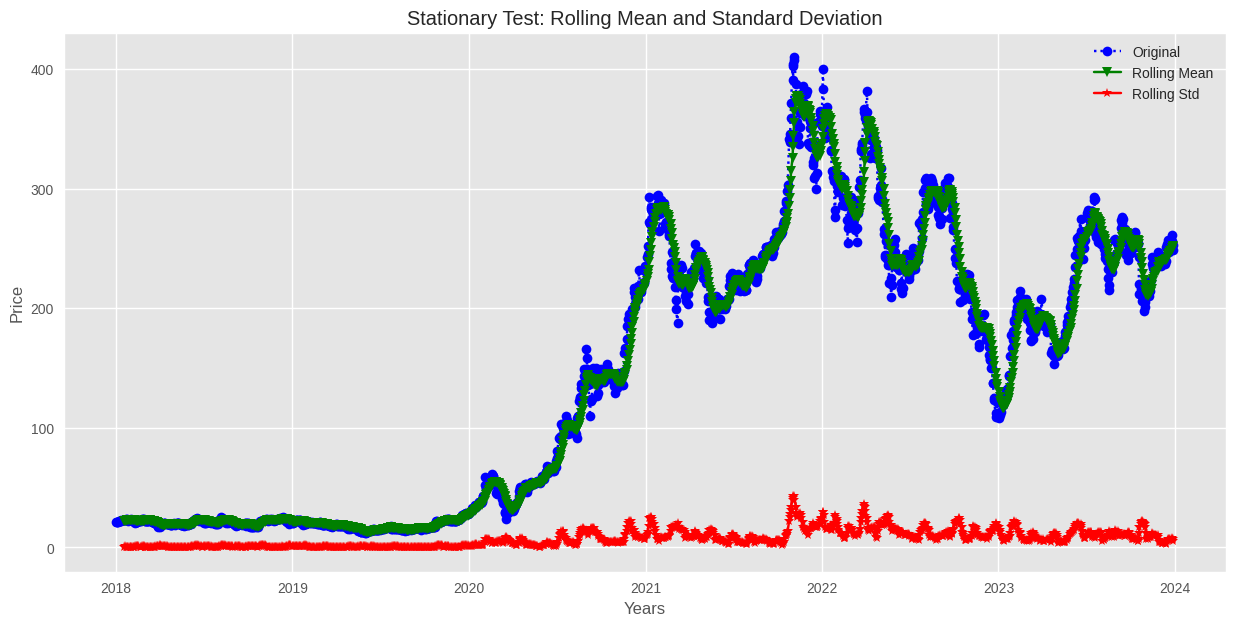

In [ ]:
# Get rolling statistics for window = 12 i.e. yearly statistics
rolling_mean =  df['Close'].rolling(window=12).mean()
rolling_std =  df['Close'].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Stationary Test: Rolling Mean and Standard Deviation')
plt.plot(df.index,  df['Close'], 'b:', marker='o', label='Original')
plt.plot(df.index, rolling_mean, 'g-', marker='v', label='Rolling Mean')
plt.plot(df.index, rolling_std, 'r-', marker='*', label='Rolling Std')
plt.legend()
plt.show()

## 3.3 Augmented Dickey Fuller test (ADF Test):
Augmented Dickey Fuller test or (ADF Test) is the most commonly used test to detect stationarity.

In [ ]:
def stationarity_test(time_series):
    time_series = time_series.dropna()

    # Plot the original time series
    plt.figure(figsize=(14, 6))
    plt.subplot(211)
    plt.plot(time_series, label='Original Series', color='blue')
    plt.title('Original Time Series')
    plt.grid(True)

    # Calculate first differences
    first_diff = time_series.diff().dropna()

    # Plot the first differenced series
    plt.subplot(212)
    plt.plot(first_diff, label='First Differences', color='orange')
    plt.title('First Differenced Series')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Perform ADF test on the first differenced series
    df_test = adfuller(first_diff)

    adf_results_df = pd.DataFrame({
        'Metric': ['ADF Statistic', 'p-value'],
        'Value': [df_test[0], df_test[1]]
    })

    critical_values_df = pd.DataFrame(df_test[4], index=['Critical Values']).T

    return adf_results_df, critical_values_df


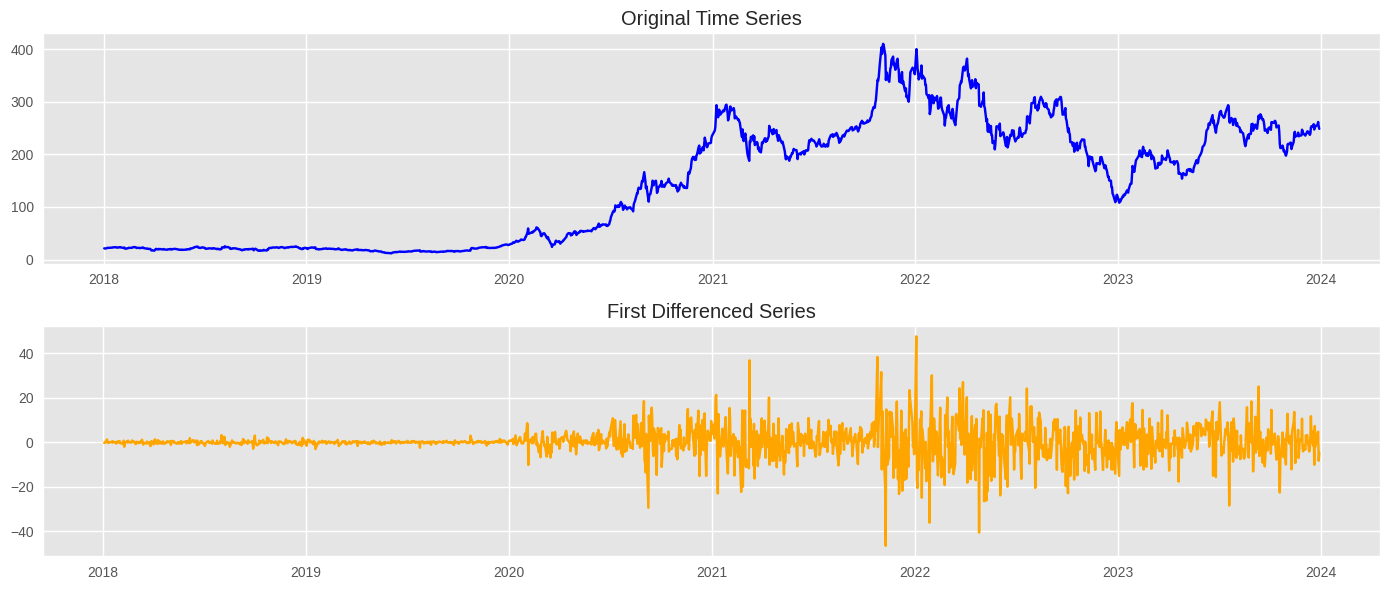

In [ ]:
# Lets test the stationarity
adf_results, critical_values = stationarity_test(df['Close'])

In [ ]:
adf_results

Metric         Value
0  ADF Statistic -7.352158e+00
1        p-value  9.994273e-11

In [ ]:
critical_values

Critical Values
1%         -3.434764
5%         -2.863490
10%        -2.567808

In [ ]:
def stationarity_test_with_lags(time_series, max_lags):
    # Ensure input is a Series and has no missing values
    time_series = time_series.dropna()

    # Calculate first differences
    first_diff = time_series.diff().dropna()

    # Prepare a DataFrame to collect ADF test results for different lags
    results = []

    for lag in range(1, max_lags + 1):
        # Perform ADF test on the first differenced series with the current lag
        df_test = adfuller(first_diff, maxlag=lag)

        # Store the results in a dictionary
        result_dict = {
            'Lag': lag,
            'ADF Statistic': df_test[0],
            'P-value': df_test[1]
        }
        results.append(result_dict)

    # Convert the list of results to a DataFrame
    results_df = pd.DataFrame(results)

    results_df.to_string(index=False)

    return results_df

In [ ]:
stationarity_test_with_lags(df['Close'], max_lags=10)

Lag  ADF Statistic       P-value
0    1     -39.998413  0.000000e+00
1    2     -39.998413  0.000000e+00
2    3     -18.351301  2.236265e-30
3    4     -18.351301  2.236265e-30
4    5     -18.351301  2.236265e-30
5    6     -13.139430  1.439546e-24
6    7     -13.008193  2.600991e-24
7    8     -11.354494  9.810357e-21
8    9     -11.332559  1.103560e-20
9   10     -11.332559  1.103560e-20

### 3.3.1 Differencing:
To transform the series using 'Differencing' we will use the diff() method of pandas.

In [ ]:
def plot_differenced_data(df):
    # Ensure 'Close' column is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    df = df.dropna(subset=['Close'])

    # First order differencing
    df_tsla_stock = df[['Close']].diff(1).bfill()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df_tsla_stock['Close'], 'b-.')
    plt.xlabel('Date')
    plt.ylabel('Differenced Price')
    plt.title('Convert Non-Stationary Data to Stationary Data Using Differencing')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

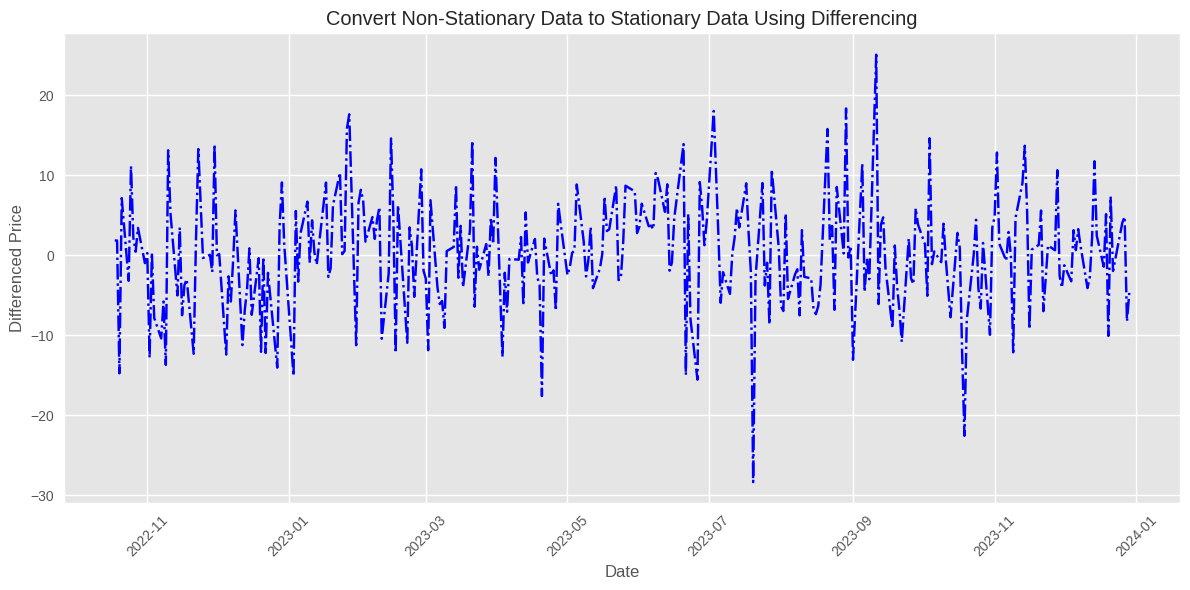

In [ ]:
plot_differenced_data(test)

In [ ]:
def plot_charts(df):

    # Create a 2x2 grid for subplots
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))

    # Plot the distribution of the 'Close' prices
    sns.histplot(df['Close'], bins=50, kde=True, color='royalblue', ax=axs[0, 0])
    axs[0, 0].set_title('Distribution of Close Prices')
    axs[0, 0].set_xlabel('Close Price')
    axs[0, 0].set_ylabel('Frequency')

    # Plot the time series of the 'Close' prices
    df['Close'].plot(ax=axs[0, 1], color='royalblue', legend=True)
    axs[0, 1].set_title('Time Series of Close Prices')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Close Price')
    axs[0, 1].legend(['Close'], loc='upper left')

    # Plot the correlation matrix
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=axs[1, 0])
    axs[1, 0].set_title('Correlation Matrix')

    # Plot the histogram of closing prices with date
    df.reset_index()['Date'].map(lambda x: x.year).hist(bins=50, color='royalblue', edgecolor='black', ax=axs[1, 1])
    axs[1, 1].set_title('Histogram of Closing Prices with Date')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid(True)

    # Adjust layout
    plt.tight_layout()
    return plt.show()

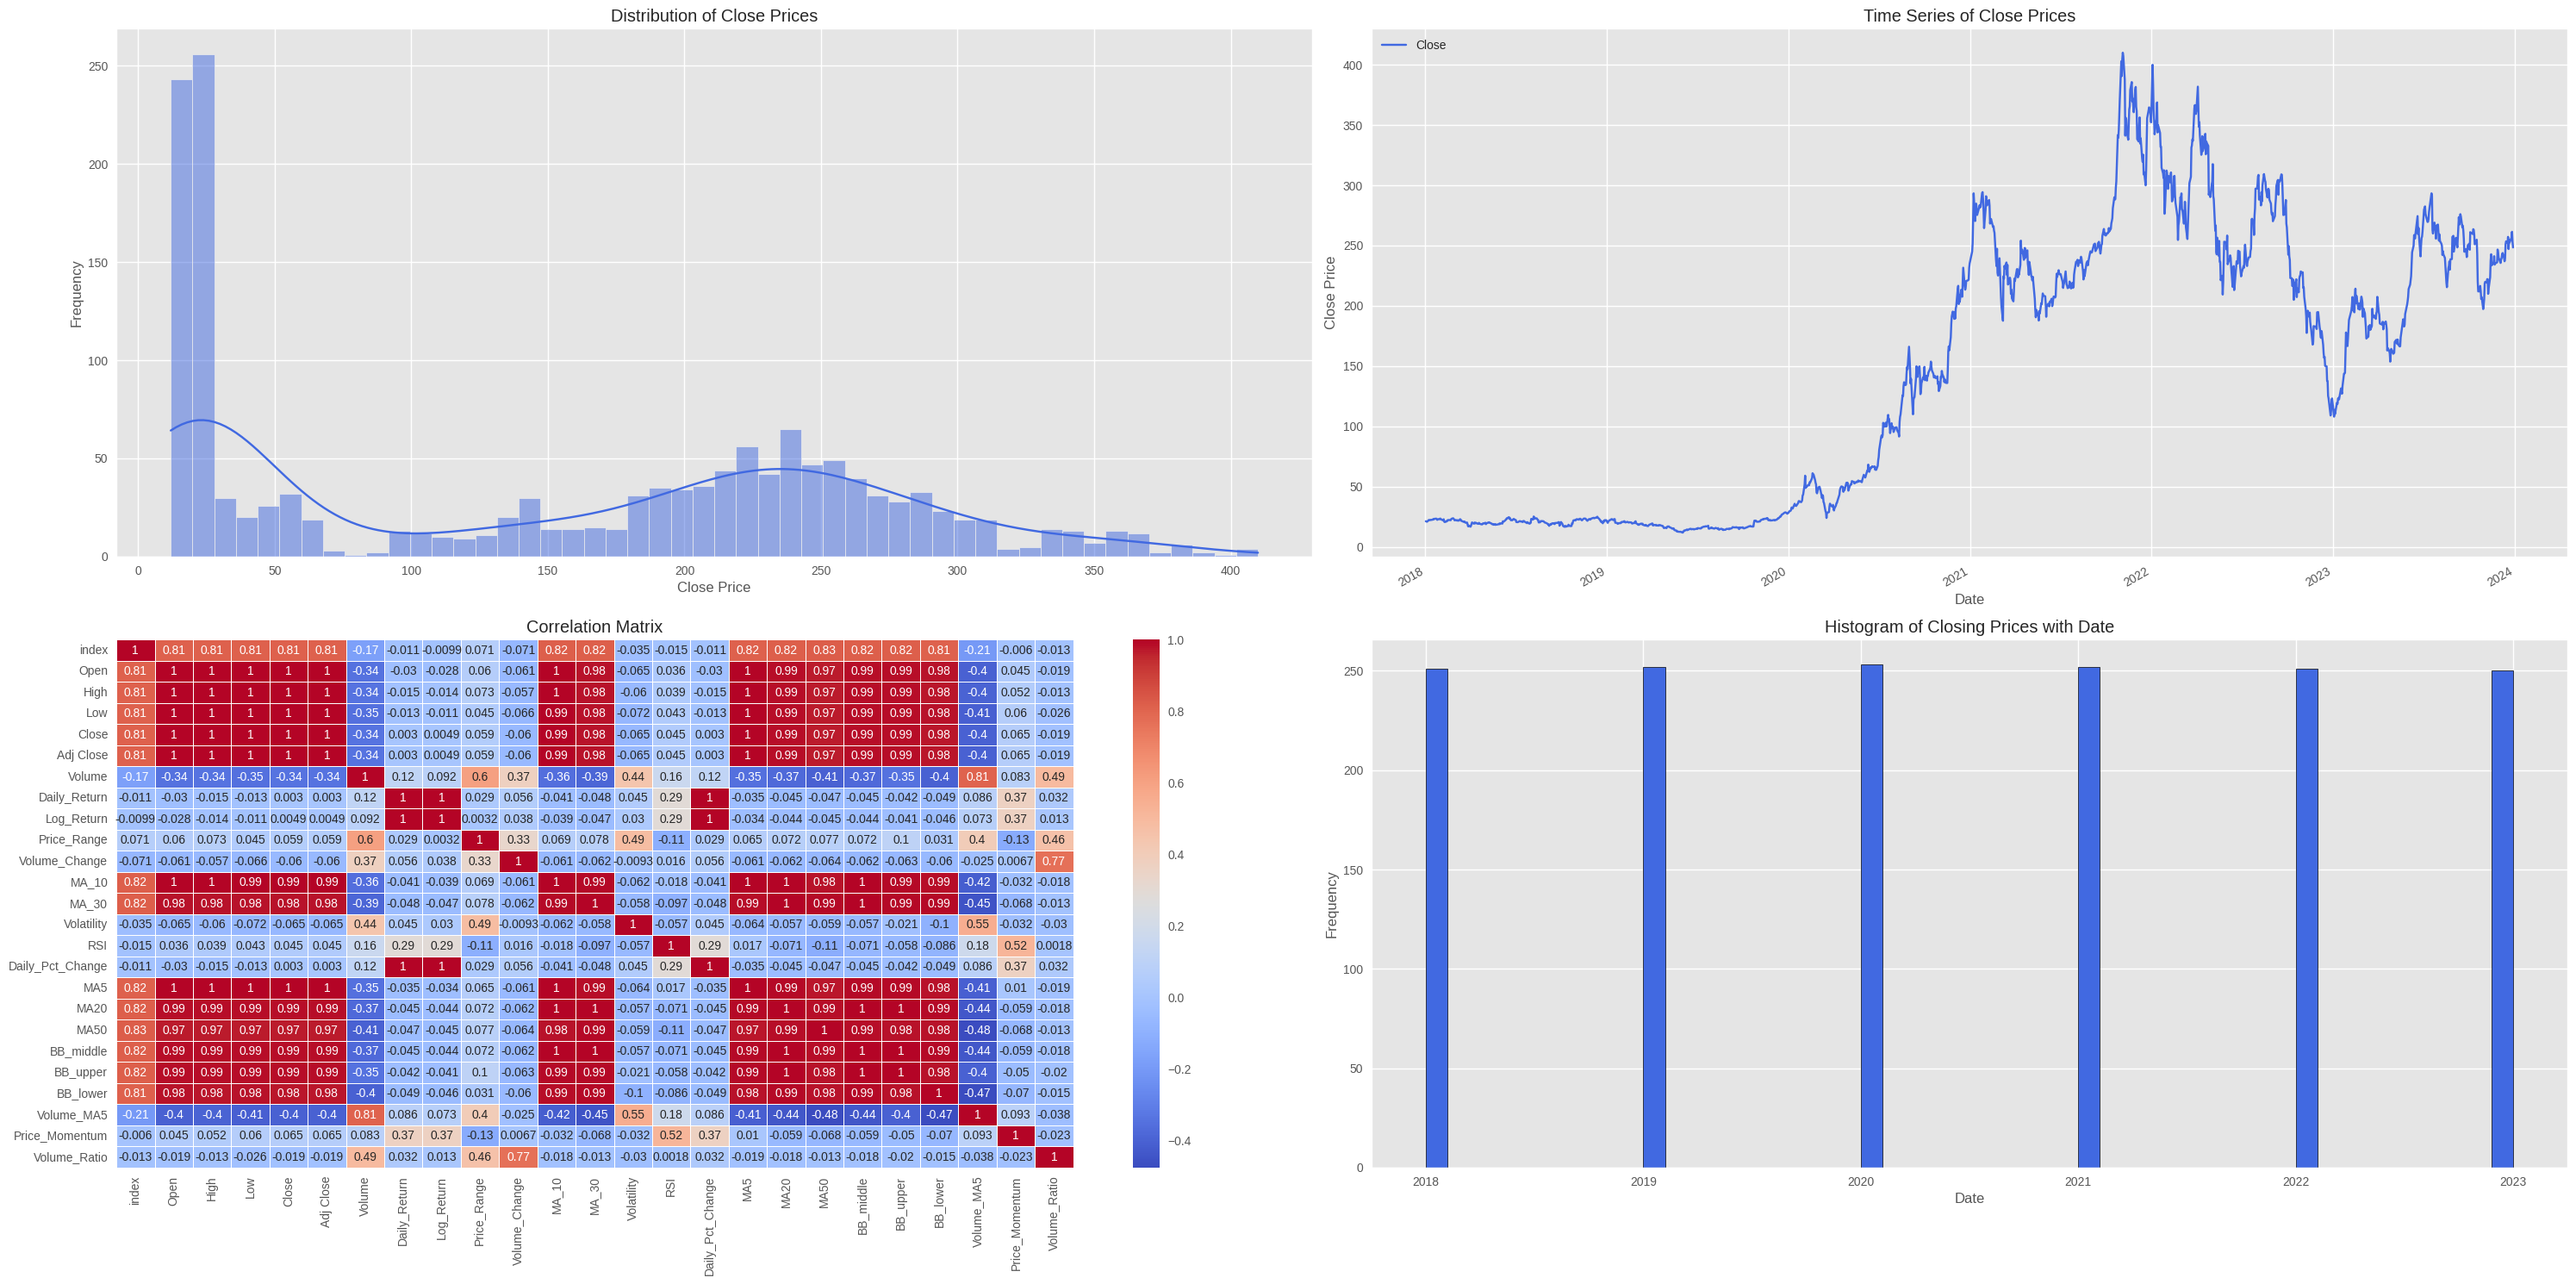

In [ ]:
plot_charts(df)

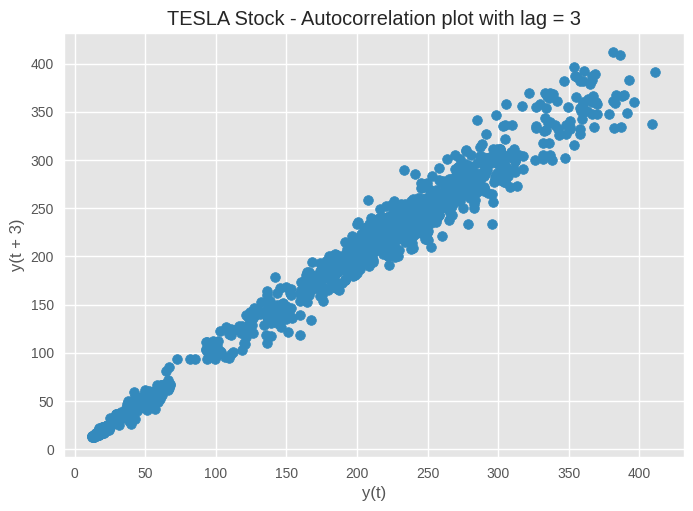

In [ ]:
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

# 4. Autoregressive Integrated Moving Average (ARIMA)


## 4.1 Autoregressive Integrated Moving Average (ARIMA)

In [ ]:
class ArimaModel:
    def __init__(self, train, test, target_column):
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column
        self.train = train[target_column].dropna()
        self.test = test[target_column].dropna()

        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        return np.abs(y_true - y_pred).mean() / d if d != 0 else float('inf')

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps))

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        try:
            results = model.fit()
            forecast = results.forecast(steps=len(self.test))
            mse = mean_squared_error(self.test, forecast)
            mae = mean_absolute_error(self.test, forecast)
            rmse = np.sqrt(mse)

            if np.any(self.test == 0):
                mape = np.nan
            else:
                mape = np.mean(np.abs((self.test - forecast) / self.test)) * 100

            smape = self.symmetric_mean_absolute_percentage_error(self.test, forecast)

            # Check if the denominator in MASE is non-zero
            mase_denom = np.abs(np.diff(self.train)).sum() / (len(self.train) - 1)
            if mase_denom == 0:
                mase = np.nan
            else:
                mase = self.mean_absolute_scaled_error(self.test, forecast)

            r_squared = r2_score(self.test, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
            aic_value = results.aic
            bic_value = results.bic

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order {order}: {e}")
            return None


    def grid_search(self, use_auto_arima=False):
        if use_auto_arima:
            model = auto_arima(self.train, seasonal=False, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)
            self.best_order = model.order
            self.best_model = ARIMA(self.train, order=self.best_order).fit()
            print(f"Best order found by auto_arima: {self.best_order}")
        else:
            p = d = q = range(0, 6)
            pdq = list(itertools.product(p, d, q))
            results = []

            for param in pdq:
                try:
                    model = ARIMA(self.train, order=param)
                    evaluation = self.evaluate_model(model, param)
                    if evaluation:
                        mse = evaluation['MSE']
                        print(f'ARIMA{param} MSE: {mse:.4f}')
                        results.append(evaluation)
                        if mse < self.best_rmse:
                            self.best_rmse = mse
                            self.best_order = param
                            self.best_model = model
                except Exception as e:
                    print(f"Error with ARIMA{param}: {e}")

            if results:
                self.results_df = pd.DataFrame(results)
                print(f"Best order found: {self.best_order} with RMSE: {self.best_rmse:.4f}")
            else:
                print("No optimal order found.")

    def fit_best_model(self):
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, order=self.best_order).fit()

    def make_forecast(self):
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test))

    def plot_results(self):
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        plt.title(f'Stock Price Forecast (ARIMA Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMAX' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMA")
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

    def display_top_orders(self, top_n=5):
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")
        return self.results_df.sort_values(by='RMSE').head(top_n)

    def plot_accuracy(self, top_n=5):
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by RMSE (or another preferred metric) and get the top N results
        top_results = self.results_df.sort_values(by='RMSE').head(top_n)
        metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'SMAPE', 'R_Squared']

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.flatten()

        for i, metric in enumerate(metrics):
            top_results.plot(x='Order', y=metric, kind='bar', ax=axes[i], legend=False)
            axes[i].set_title(f'{metric} for Top {top_n} ARIMA Orders')
            axes[i].set_xlabel('ARIMA Order')
            axes[i].set_ylabel(metric)
            axes[i].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()


    def plot_accuracy_(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMA Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMAX model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

    def plot_acf_pacf(self, lags=40):
        """
        Plots the ACF and PACF of the training data.

        Parameters:
        lags (int): Number of lags to include in the plots.
        """
        plt.figure(figsize=(14, 7))

        plt.subplot(121)
        plot_acf(self.train, lags=lags, ax=plt.gca())
        plt.title('Autocorrelation Function (ACF)')

        plt.subplot(122)
        plot_pacf(self.train, lags=lags, ax=plt.gca())
        plt.title('Partial Autocorrelation Function (PACF)')

        plt.tight_layout()
        plt.show()

In [ ]:
train.dtypes

index          int64
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
arima_model = ArimaModel(train, test, target_column='Close')

In [ ]:
# Perform grid search
arima_model.grid_search()

ARIMA(0, 0, 0) MSE: 8460.3811
ARIMA(0, 0, 1) MSE: 8435.7317
ARIMA(0, 0, 2) MSE: 8434.2531
ARIMA(0, 0, 3) MSE: 8445.3089
ARIMA(0, 0, 4) MSE: 8388.6366
ARIMA(0, 0, 5) MSE: 8394.9711
ARIMA(0, 1, 0) MSE: 1891.7027
ARIMA(0, 1, 1) MSE: 1890.7273
ARIMA(0, 1, 2) MSE: 1893.5208
ARIMA(0, 1, 3) MSE: 1893.4009
ARIMA(0, 1, 4) MSE: 1896.5997
ARIMA(0, 1, 5) MSE: 1896.7544
ARIMA(0, 2, 0) MSE: 21583.6850
ARIMA(0, 2, 1) MSE: 2354.2554
ARIMA(0, 2, 2) MSE: 2312.6537
ARIMA(0, 2, 3) MSE: 2359.8098
ARIMA(0, 2, 4) MSE: 2361.9816
ARIMA(0, 2, 5) MSE: 2374.0272
ARIMA(0, 3, 0) MSE: 77217149814.1522
ARIMA(0, 3, 1) MSE: 26641.6304
ARIMA(0, 3, 2) MSE: 117045.9783
ARIMA(0, 3, 3) MSE: 92803.8784
ARIMA(0, 3, 4) MSE: 38671.2237
ARIMA(0, 3, 5) MSE: 24067.1406
ARIMA(0, 4, 0) MSE: 6245450434561344.0000
ARIMA(0, 4, 1) MSE: 88727996552.2843
ARIMA(0, 4, 2) MSE: 13942012.0869
ARIMA(0, 4, 3) MSE: 1524358.4601
ARIMA(0, 4, 4) MSE: 2693590.7396
ARIMA(0, 4, 5) MSE: 3087632.7963
ARIMA(0, 5, 0) MSE: 134824525511983759360.0000
ARIMA(0

In [ ]:
# Fit the best model (0,1,1) - corresponds to simple exponential smoothing
arima_model.fit_best_model()

In [ ]:
# Make forecast and plot results
arima_model.make_forecast()

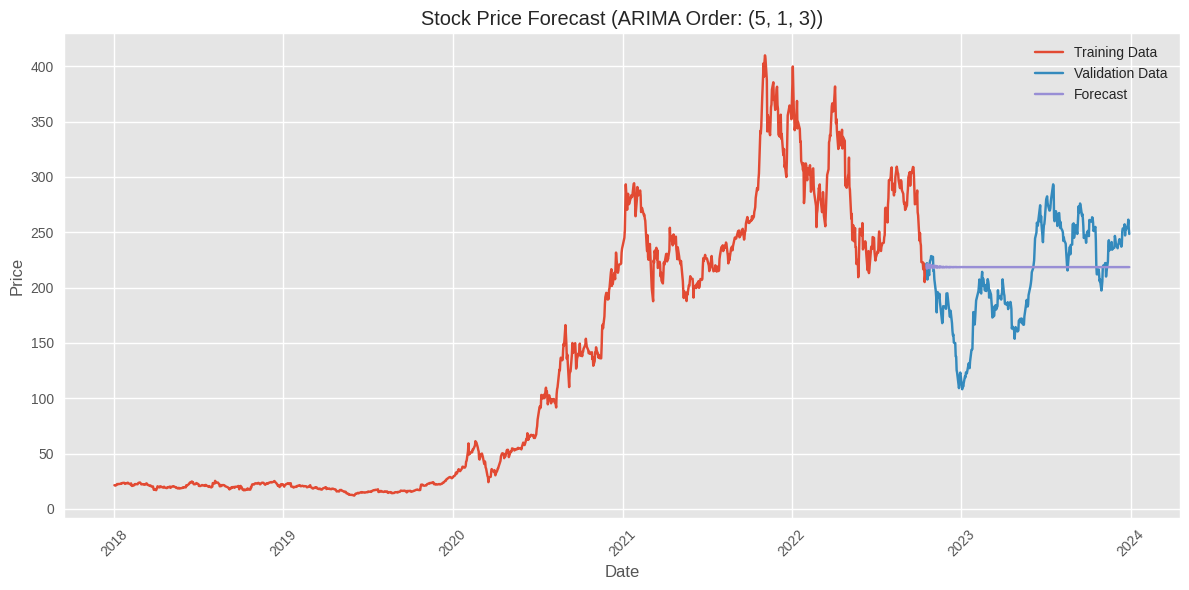

In [ ]:
arima_model.plot_results()

In [ ]:
# arima_model.plot_accuracy()

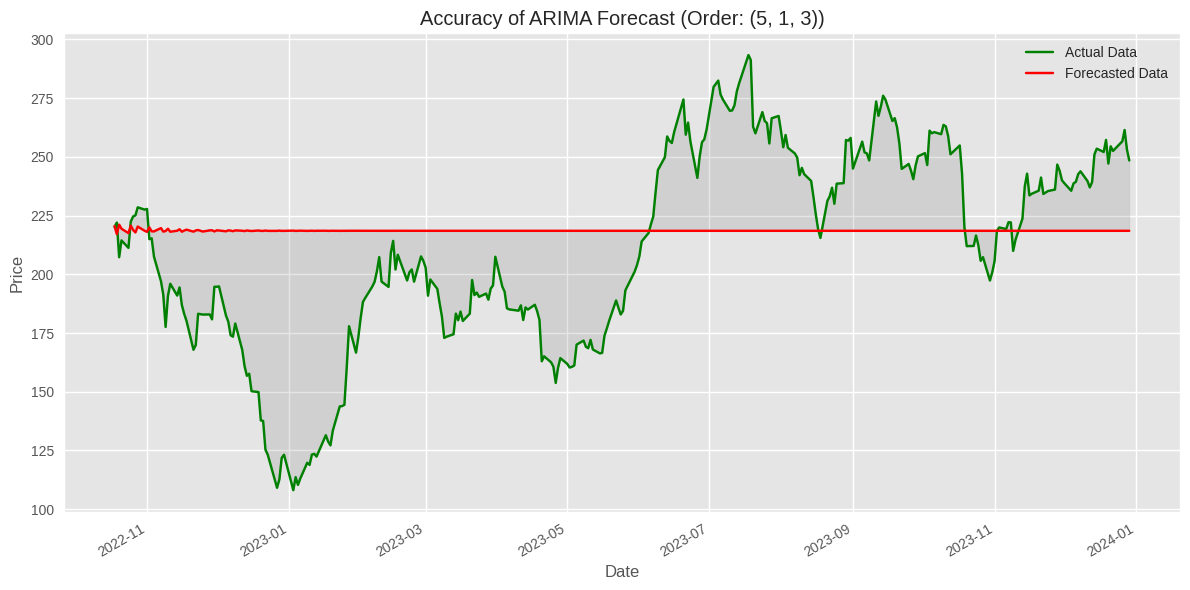

In [ ]:
arima_model.plot_accuracy_()

In [ ]:
# Print evaluation metrics and model summary
arima_model.print_evaluation_metrics()

Final Mean Squared Error: 1865.3657832883282
Final Mean Absolute Error: 36.27389479192665
Final Root Mean Squared Error: 43.18988056580301


In [ ]:
arima_model.print_model_summary()

                               ARIMA Results                                
Dep. Variable:                  Close   No. Observations:                 1208
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -4034.799
Date:                Wed, 28 Aug 2024   AIC                           8087.599
Time:                        07:22:30   BIC                           8133.462
Sample:                             0   HQIC                          8104.870
                               - 1208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2614      0.406     -0.644      0.519      -1.057       0.534
ar.L2          0.0958      0.458      0.209      0.834      -0.801       0.993
ar.L3          0.7889      0.363      2.173      0.030

In [ ]:
# Display the top 5 model orders
arima_model.display_top_orders()

Order          MSE        MAE       RMSE  R_Squared  Adj_R_Squared  \
189  (5, 1, 3)  1865.365783  36.273895  43.189881  -0.029467      -0.039830   
116  (3, 1, 2)  1874.952577  36.321536  43.300723  -0.034757      -0.045174   
153  (4, 1, 3)  1881.045326  36.357476  43.371019  -0.038120      -0.048571   
79   (2, 1, 1)  1882.376260  36.357763  43.386360  -0.038854      -0.049313   
115  (3, 1, 1)  1882.471716  36.358725  43.387460  -0.038907      -0.049366   

             AIC          BIC  
189  8087.598915  8133.461954  
116  8085.646122  8116.221481  
153  8086.443158  8127.210303  
79   8107.309870  8127.693443  
115  8109.261926  8134.741392

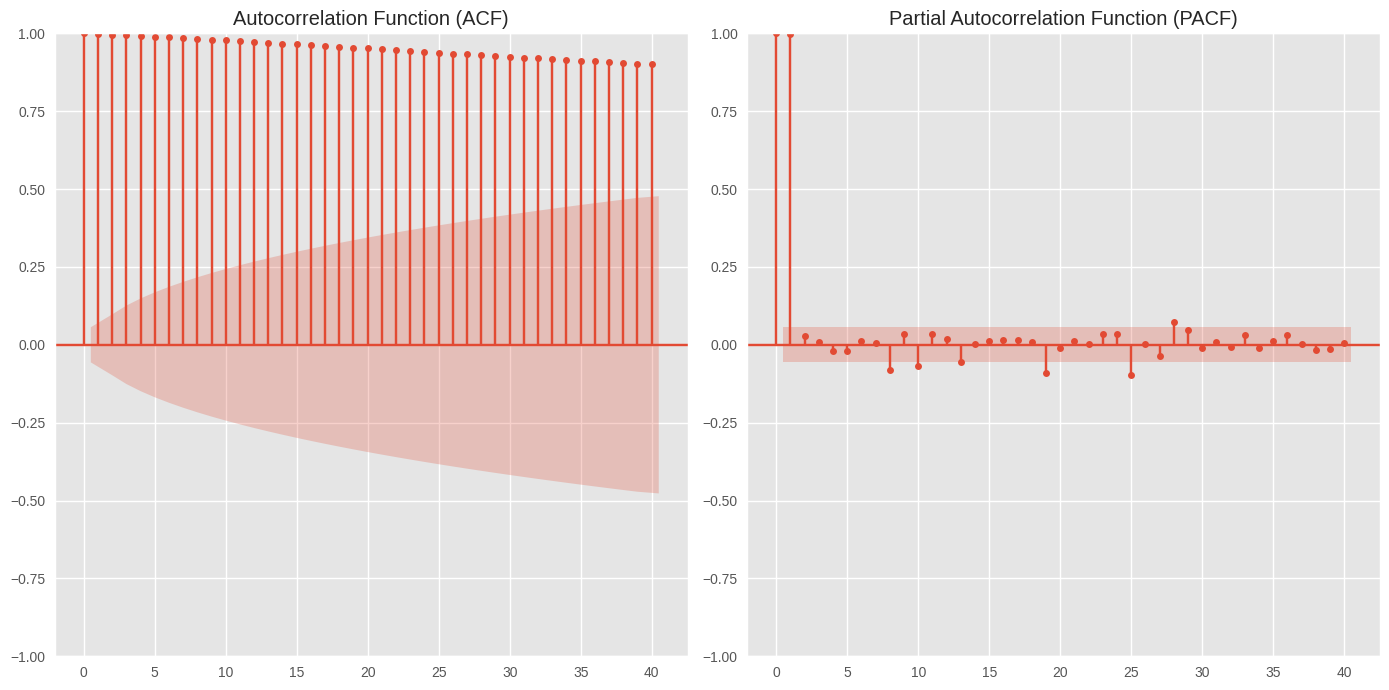

In [ ]:
arima_model.plot_acf_pacf()

## 4.2 ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables)


In [ ]:
class ARIMAXModel:
    def __init__(self, train, test, target_column, exog_vars):
        """
        Initializes the ARIMAXModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for ARIMAX modeling.
        exog_vars (list): List of exogenous variables to use in the model.
        """
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column
        self.exog_vars = exog_vars

        # Extract the target column as a Series and ensure data is numeric and clean
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()
        self.train_exog = train[exog_vars]
        self.test_exog = test[exog_vars]

        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero_mask = y_true != 0
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps)
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / denominator)

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        if d == 0:
            return float('inf')  # Returning infinity if naive forecast method is not valid
        return np.abs(y_true - y_pred).mean() / d

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            results = model.fit()
            forecast = results.forecast(steps=len(self.test), exog=self.test_exog)
            mse = mean_squared_error(self.test, forecast)
            mae = mean_absolute_error(self.test, forecast)
            rmse = np.sqrt(mse)
            mape = self.mean_absolute_percentage_error(self.test, forecast)
            smape = self.symmetric_mean_absolute_percentage_error(self.test, forecast)
            mase = self.mean_absolute_scaled_error(self.test, forecast)
            r_squared = r2_score(self.test, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
            aic_value = results.aic
            bic_value = results.bic

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order {order}: {e}")
            return None

    def grid_search(self):
        """
        Performs a grid search to find the most optimal ARIMAX model order based on the lowest MSE.
        """
        p = d = q = range(0, 6)
        pdq = list(itertools.product(p, d, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param  # Unpack the current order
                model = ARIMA(self.train, exog=self.train_exog, order=param)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'ARIMAX(p={p}, d={d}, q={q}) MSE: {mse:.4f}')

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")

    def fit_best_model(self):
        """
        Fits the best ARIMAX model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, exog=self.train_exog, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        """
        Makes forecast using the best fitted ARIMAX model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test), exog=self.test_exog)

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the ARIMAX (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with ARIMAX order
        plt.title(f'Stock Price Forecast (ARIMAX Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'ARIMAX Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMAX Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMAX' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMAX")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

    def display_top_orders(self, top_n=5):
        """
        Displays the top N ARIMAX model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} ARIMAX model orders with the lowest MSE:")

        return top_results

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMAX model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

    def plot_acf_pacf(self, lags=40):
        """
        Plots the ACF and PACF of the training data.

        Parameters:
        lags (int): Number of lags to include in the plots.
        """
        plt.figure(figsize=(14, 7))

        plt.subplot(121)
        plot_acf(self.train, lags=lags, ax=plt.gca())
        plt.title('Autocorrelation Function (ACF)')

        plt.subplot(122)
        plot_pacf(self.train, lags=lags, ax=plt.gca())
        plt.title('Partial Autocorrelation Function (PACF)')

        plt.tight_layout()
        plt.show()

In [ ]:
# Initialize the model
arimax_model = ARIMAXModel(train=train, test=test, target_column='Close', exog_vars=['Open', 'High', 'Low', 'Volume'])

In [ ]:
# Perform grid search
arimax_model.grid_search()

ARIMAX(p=0, d=0, q=0) MSE: 6.2368
ARIMAX(p=0, d=0, q=1) MSE: 6.2369
ARIMAX(p=0, d=0, q=2) MSE: 6.2369
ARIMAX(p=0, d=0, q=3) MSE: 6.2348
ARIMAX(p=0, d=0, q=4) MSE: 6.2364
ARIMAX(p=0, d=0, q=5) MSE: 6.2326
ARIMAX(p=0, d=1, q=0) MSE: 82.2444
ARIMAX(p=0, d=1, q=1) MSE: 73.8948
ARIMAX(p=0, d=1, q=2) MSE: 73.5050
ARIMAX(p=0, d=1, q=3) MSE: 74.1201
ARIMAX(p=0, d=1, q=4) MSE: 73.3568
ARIMAX(p=0, d=1, q=5) MSE: 73.3301
ARIMAX(p=0, d=2, q=0) MSE: 597884.9354
ARIMAX(p=0, d=2, q=1) MSE: 597884.9354
ARIMAX(p=0, d=2, q=2) MSE: 8080.3728
ARIMAX(p=0, d=2, q=3) MSE: 597884.9354
ARIMAX(p=0, d=2, q=4) MSE: 22042.9127
ARIMAX(p=0, d=2, q=5) MSE: 597884.9354
ARIMAX(p=0, d=3, q=0) MSE: 461272884.8138
ARIMAX(p=0, d=3, q=1) MSE: 461272884.8138
ARIMAX(p=0, d=3, q=2) MSE: 943313160.2581
ARIMAX(p=0, d=3, q=3) MSE: 461272884.8138
ARIMAX(p=0, d=3, q=4) MSE: 461272884.8138
ARIMAX(p=0, d=3, q=5) MSE: 461272884.8138
ARIMAX(p=0, d=4, q=0) MSE: 248466856043732.7188
ARIMAX(p=0, d=4, q=1) MSE: 248466856043728.0625
ARIMAX(

In [ ]:
# Fit the best model
arimax_model.fit_best_model()

In [ ]:
# Make the forecast
arimax_model.make_forecast()

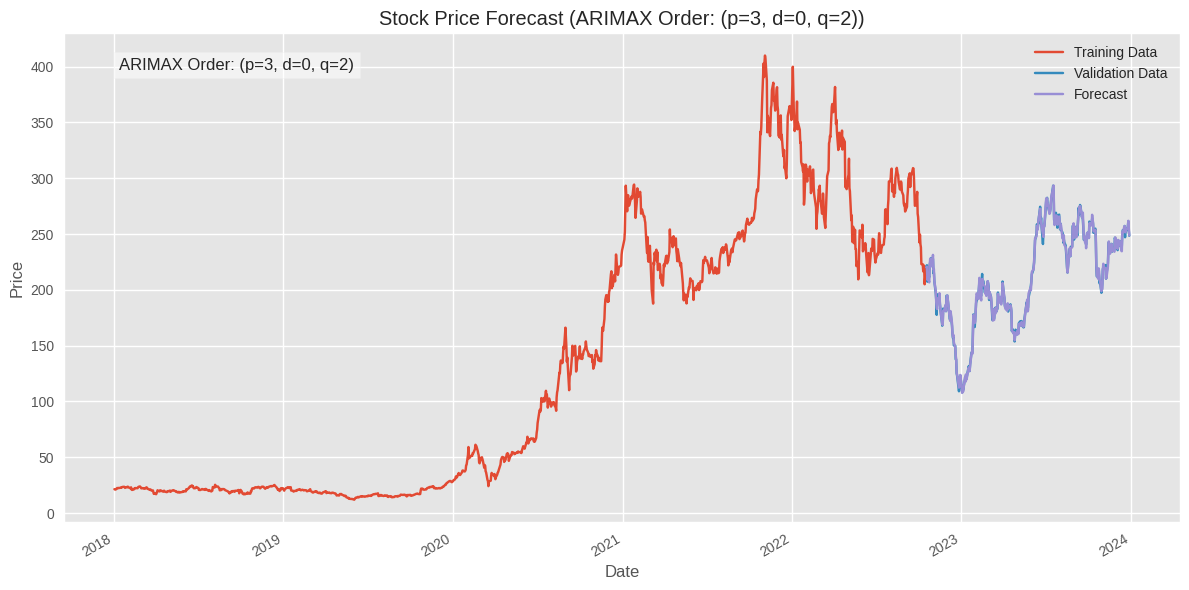

In [ ]:
# Plot the results
arimax_model.plot_results()

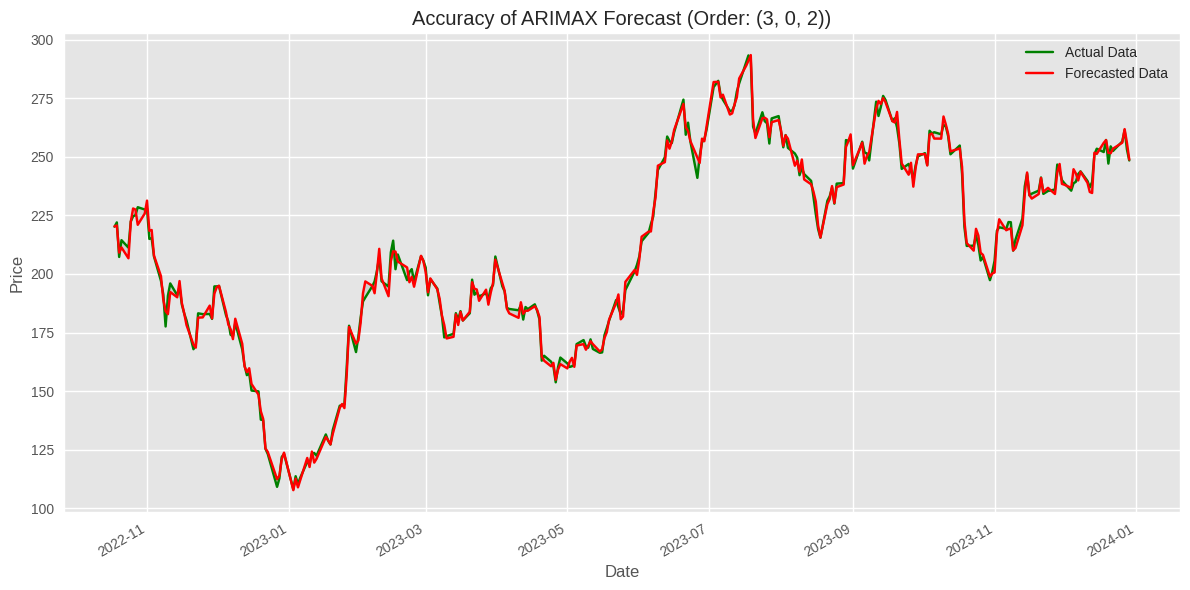

In [ ]:
# Plot forecast accuracy
arimax_model.plot_accuracy()

In [ ]:
# Print evaluation metrics
arimax_model.print_evaluation_metrics()

Final Mean Squared Error: 6.2247620593571815
Final Mean Absolute Error: 1.9620564719818199
Final Root Mean Squared Error: 2.494947305927959


In [ ]:
# Print model summary
arimax_model.print_model_summary()

                               ARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1208
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2804.559
Date:                Wed, 28 Aug 2024   AIC                           5631.118
Time:                        07:31:25   BIC                           5687.182
Sample:                             0   HQIC                          5652.230
                               - 1208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0783    1.1e-05  -7098.085      0.000      -0.078      -0.078
Open          -0.6737      0.004   -159.964      0.000      -0.682      -0.665
High           0.8701      0.001   1428.122      0.00

In [ ]:
# Display top model orders
arimax_model.display_top_orders(top_n=5)

Top 5 ARIMAX model orders with the lowest MSE:


Order       MSE       MAE      RMSE      MAPE     SMAPE      MASE  \
110  (3, 0, 2)  6.224762  1.962056  2.494947  0.952904  0.952402  0.359428   
75   (2, 0, 3)  6.231196  1.962894  2.496236  0.953291  0.952789  0.359581   
77   (2, 0, 5)  6.231803  1.962893  2.496358  0.953286  0.952787  0.359581   
180  (5, 0, 0)  6.232007  1.962989  2.496399  0.953335  0.952836  0.359598   
181  (5, 0, 1)  6.232448  1.962868  2.496487  0.953281  0.952782  0.359576   

     R_Squared  Adj_R_Squared          AIC          BIC  
110   0.996565       0.996530  5631.118259  5687.182194  
75    0.996561       0.996526  5630.590144  5686.654079  
77    0.996561       0.996526  5633.208500  5699.465878  
180   0.996561       0.996526  5628.885587  5684.949523  
181   0.996560       0.996526  5630.913459  5692.074116

In [ ]:
# Get the best order and forecast
best_order = arimax_model.get_best_order()

In [ ]:
forecast = arimax_model.get_forecast()

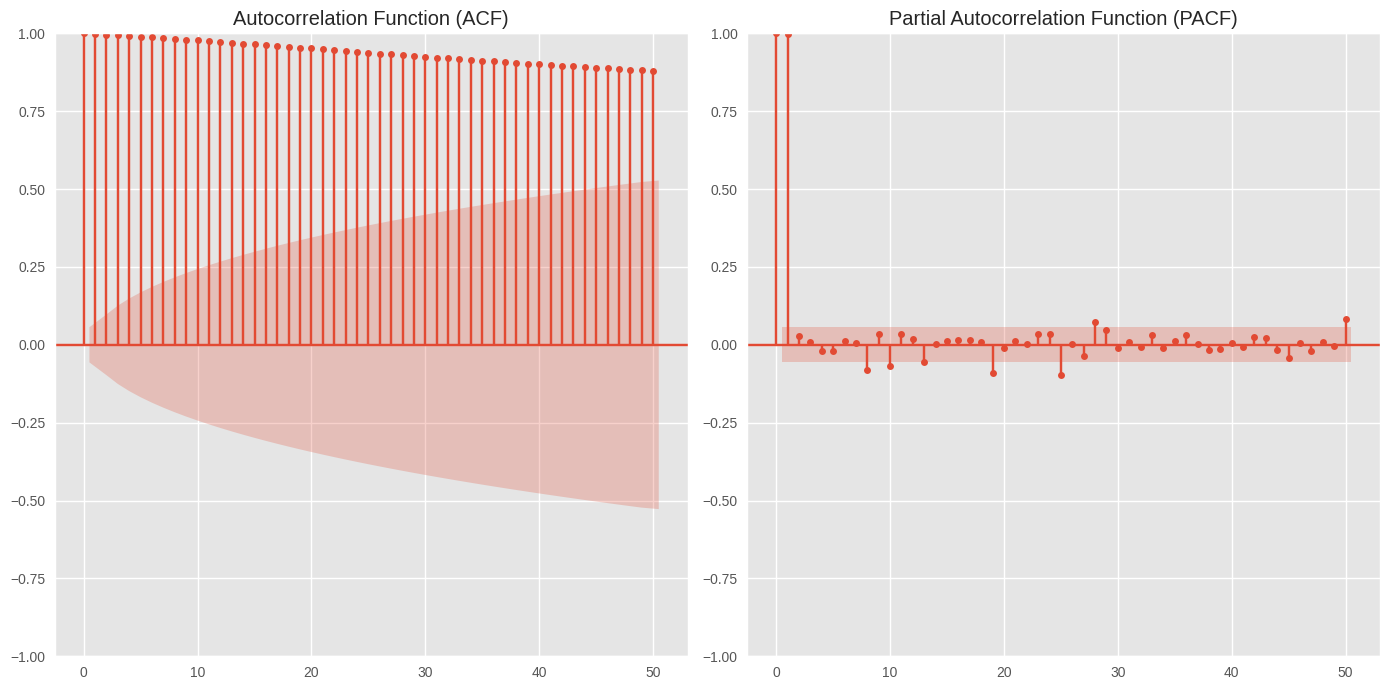

In [ ]:
# To plot the ACF and PACF:
arimax_model.plot_acf_pacf(lags=50)

# 4.3 SARIMA with Trend

In [ ]:
class SARIMATrend:
    def __init__(self, train, test, target_column):
        self.train = train
        self.test = test
        self.target_column = target_column
        self.best_model = None
        self.forecast = None
        self.best_mse = float('inf')
        self.best_order = None
        self.best_seasonal_order = None
        self.best_trend = None
        self.model_performance = []

    def fit_sarima(self, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), trend='n'):
        try:
            model = SARIMAX(self.train[self.target_column], order=order, seasonal_order=seasonal_order, trend=trend)
            results = model.fit(disp=False)
            return results
        except Exception as e:
            print(f"An error occurred while fitting the SARIMA model with order={order}, seasonal_order={seasonal_order}, trend={trend}: {e}")
            return None

    def make_forecast(self):
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.get_forecast(steps=len(self.test)).predicted_mean
        return self.forecast

    def adjusted_r_squared(self, r_squared, n, k):
        """Calculate adjusted R-squared."""
        return 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

    def mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def symmetric_mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(2.0 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

    def mean_absolute_scaled_error(self, y_true, y_pred):
        mae = np.mean(np.abs(y_true - y_pred))
        naive_mae = np.mean(np.abs(np.diff(y_true)))
        return mae / naive_mae

    def evaluate_model(self, model, order):
        try:
            results = model.fit(disp=False)
            forecast = results.get_forecast(steps=len(self.test)).predicted_mean
            mse = mean_squared_error(self.test[self.target_column], forecast)
            mae = mean_absolute_error(self.test[self.target_column], forecast)
            rmse = np.sqrt(mse)
            mape = self.mean_absolute_percentage_error(self.test[self.target_column], forecast)
            smape = self.symmetric_mean_absolute_percentage_error(self.test[self.target_column], forecast)
            mase = self.mean_absolute_scaled_error(self.test[self.target_column], forecast)
            r_squared = r2_score(self.test[self.target_column], forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
            aic_value = results.aic
            bic_value = results.bic

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order {order}: {e}")
            return None

    def run_grid_search(self, p_values, d_values, q_values, P_values, D_values, Q_values, m_values, trend_options):
        for order in itertools.product(p_values, d_values, q_values):
            for seasonal_order in itertools.product(P_values, D_values, Q_values, m_values):
                for trend in trend_options:
                    sarima_model = SARIMAX(self.train[self.target_column], order=order, seasonal_order=seasonal_order, trend=trend)
                    performance = self.evaluate_model(sarima_model, order)
                    if performance:
                        self.model_performance.append(performance)
                        if performance['MSE'] < self.best_mse:
                            self.best_mse = performance['MSE']
                            self.best_order = order
                            self.best_seasonal_order = seasonal_order
                            self.best_trend = trend
                            print(f"New best model found: {performance}")

        print(f"Best model: Order={self.best_order}, Seasonal Order={self.best_seasonal_order}, Trend={self.best_trend}, MSE={self.best_mse}")

    def fit_best_model(self):
        if self.best_order is None or self.best_seasonal_order is None:
            raise ValueError("Best model parameters not set. Please run grid search first.")
        self.best_model = self.fit_sarima(order=self.best_order, seasonal_order=self.best_seasonal_order, trend=self.best_trend)
        self.forecast = self.make_forecast()

    def plot_results(self):
        if self.forecast is None:
            raise ValueError("No forecast available. Please run make_forecast first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train[self.target_column], label='Training Data')
        plt.plot(self.test.index, self.test[self.target_column], label='Test Data')
        plt.plot(self.test.index, self.forecast, label='SARIMA with Trend Forecast')

        title = (
            f'SARIMA with Trend Forecast\n'
            f'Order={self.best_order}, Seasonal Order={self.best_seasonal_order}, Trend={self.best_trend}'
        )
        plt.title(title)
        plt.legend()
        plt.show()

    def display_top_orders(self, n=5):
        sorted_models = sorted(self.model_performance, key=lambda x: x['MSE'])
        top_models = sorted_models[:n]

        df_top_models = pd.DataFrame(top_models)
        print(df_top_models)
        return df_top_models

    def plot_accuracy(self):
        if self.forecast is None:
            raise ValueError("No forecast available. Please run make_forecast or fit_best_model first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test[self.target_column], label='Actual')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.title('Forecast Accuracy')
        plt.legend()
        plt.show()

    def print_evaluation_metrics(self):
        print(f"Best Model MSE: {self.best_mse}")

    def residual_diagnostics(self):
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        residuals = self.best_model.resid
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Residuals over time
        axes[0, 0].plot(residuals)
        axes[0, 0].set_title('Residuals over Time')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Residual')

        # Histogram of residuals
        axes[0, 1].hist(residuals, bins=30)
        axes[0, 1].set_title('Histogram of Residuals')
        axes[0, 1].set_xlabel('Residual')
        axes[0, 1].set_ylabel('Frequency')

        # Q-Q plot
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot')

        # ACF of residuals
        from statsmodels.graphics.tsaplots import plot_acf
        plot_acf(residuals, ax=axes[1, 1])
        axes[1, 1].set_title('ACF of Residuals')

        plt.tight_layout()
        plt.show()

        # Ljung-Box test
        from statsmodels.stats.diagnostic import acorr_ljungbox
        lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30])
        print("Ljung-Box test results:")
        print(lb_test)


    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMAX' in the summary
        modified_summary = original_summary.replace("SARIMAX", "SARIMA")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

    def plot_acf_pacf(self, lags=50):
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        plot_acf(self.train[self.target_column], lags=lags, ax=ax[0])
        ax[0].set_title('Autocorrelation Function')
        plot_pacf(self.train[self.target_column], lags=lags, ax=ax[1])
        ax[1].set_title('Partial Autocorrelation Function')
        plt.show()

    def get_best_order(self):
        return self.best_order, self.best_seasonal_order, self.best_trend

    def get_forecast(self):
        if self.forecast is None:
            raise ValueError("No forecast available. Please run make_forecast or fit_best_model first.")
        return self.forecast
    # Add any additional methods you need below


In [ ]:
# Parameters for grid search
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
m_values = [12]  # seasonal period (e.g., 12 for monthly seasonality)
trend_options = ['n', 'c', 't', 'ct']  # 'n' = no trend, 'c' = constant, 't' = linear trend, 'ct' = both

# Create an instance of SARIMA_Trend_Model
sarima_model = SARIMATrend(train=train, test=test, target_column=target_column)

In [ ]:
# Run grid search with SARIMA and Trend component
sarima_model.run_grid_search(p_values, d_values, q_values, P_values, D_values, Q_values, m_values, trend_options)

print("SARIMA with Trend grid search completed successfully.")

New best model found: {'Order': (0, 0, 0), 'MSE': 46443.124328291255, 'MAE': 211.2608605189039, 'RMSE': 215.50666887196613, 'MAPE': nan, 'SMAPE': nan, 'MASE': nan, 'R_Squared': -24.631243242384777, 'Adj_R_Squared': -24.8892758924759, 'AIC': 15928.42375640473, 'BIC': 15933.520477783226}
New best model found: {'Order': (0, 0, 0), 'MSE': 8460.38026449388, 'MAE': 82.73705403268677, 'RMSE': 91.98032542067831, 'MAPE': nan, 'SMAPE': nan, 'MASE': nan, 'R_Squared': -3.669153241058291, 'Adj_R_Squared': -3.716158139458207, 'AIC': 14991.324096409468, 'BIC': 15001.517539166458}
New best model found: {'Order': (0, 0, 0), 'MSE': 8410.666371714791, 'MAE': 82.29501196424626, 'RMSE': 91.70968526668703, 'MAPE': nan, 'SMAPE': nan, 'MASE': nan, 'R_Squared': -3.641716911208052, 'Adj_R_Squared': -3.688445604945046, 'AIC': 13658.507126764898, 'BIC': 13673.797290900382}
New best model found: {'Order': (0, 0, 0), 'MSE': 2232.410182467664, 'MAE': 38.806953834382114, 'RMSE': 47.248388146768185, 'MAPE': nan, 'SMAP

In [ ]:
sarima_model.fit_best_model()

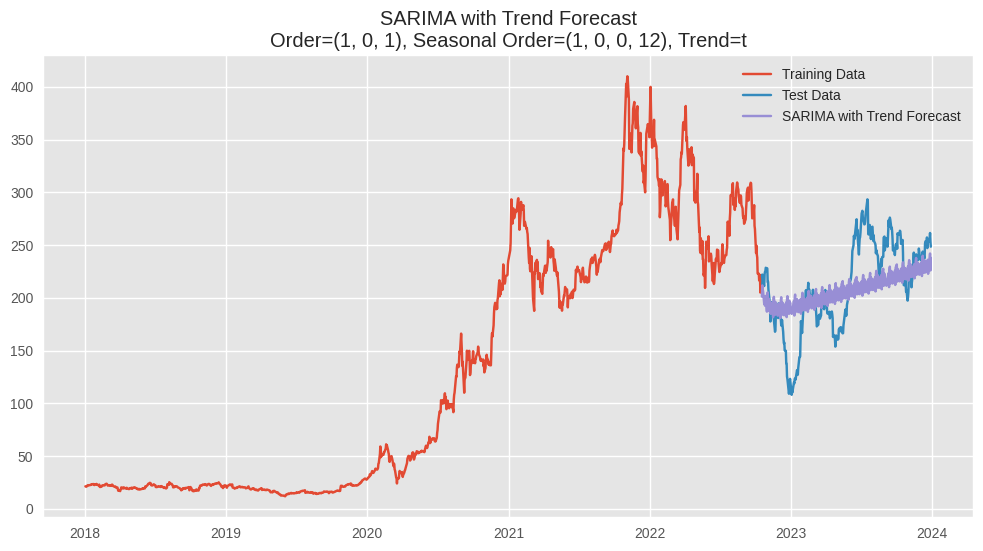

In [ ]:
sarima_model.plot_results()   # Plot the SARIMA model with the trend forecast

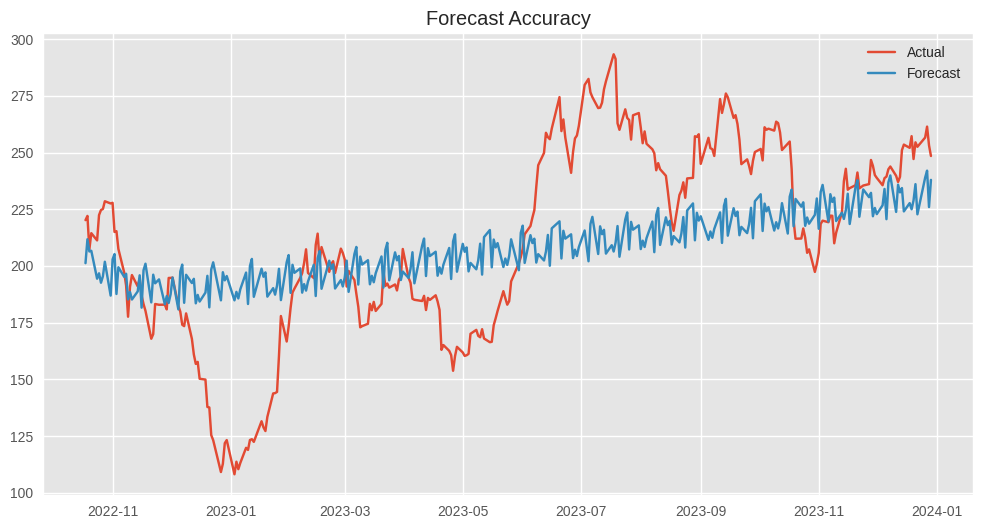

In [ ]:
sarima_model.plot_accuracy()

In [ ]:
sarima_model.print_model_summary()

                                      SARIMA Results                                      
Dep. Variable:                               Close   No. Observations:                 1208
Model:             SARIMA(1, 0, 1)x(1, 0, [], 12)   Log Likelihood               -4453.363
Date:                             Wed, 28 Aug 2024   AIC                           8916.726
Time:                                     07:47:09   BIC                           8942.209
Sample:                                          0   HQIC                          8926.322
                                            - 1208                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.000      0.495      0.620      -0.000       0.001
ar.L1          0.9178      0.

In [ ]:
sarima_model.print_evaluation_metrics()

Best Model MSE: 1239.2142217898115


In [ ]:
sarima_model.display_top_orders()

       Order          MSE        MAE       RMSE  MAPE  SMAPE  MASE  R_Squared  \
0  (1, 0, 1)  1239.214222  28.231810  35.202475   NaN    NaN   NaN   0.316097   
1  (1, 0, 0)  1295.694281  29.037150  35.995754   NaN    NaN   NaN   0.284926   
2  (1, 0, 1)  1335.590120  29.515630  36.545726   NaN    NaN   NaN   0.262908   
3  (1, 0, 0)  1361.323913  29.798140  36.896123   NaN    NaN   NaN   0.248706   
4  (1, 0, 1)  1375.586619  30.083464  37.088902   NaN    NaN   NaN   0.240835   

   Adj_R_Squared          AIC          BIC  
0       0.309212  8916.725620  8942.209227  
1       0.277728  8918.432115  8943.915722  
2       0.255488  8772.869944  8793.216896  
3       0.241143  8771.012842  8786.273056  
4       0.233192  8772.705974  8793.052925  


Order          MSE        MAE       RMSE  MAPE  SMAPE  MASE  R_Squared  \
0  (1, 0, 1)  1239.214222  28.231810  35.202475   NaN    NaN   NaN   0.316097   
1  (1, 0, 0)  1295.694281  29.037150  35.995754   NaN    NaN   NaN   0.284926   
2  (1, 0, 1)  1335.590120  29.515630  36.545726   NaN    NaN   NaN   0.262908   
3  (1, 0, 0)  1361.323913  29.798140  36.896123   NaN    NaN   NaN   0.248706   
4  (1, 0, 1)  1375.586619  30.083464  37.088902   NaN    NaN   NaN   0.240835   

   Adj_R_Squared          AIC          BIC  
0       0.309212  8916.725620  8942.209227  
1       0.277728  8918.432115  8943.915722  
2       0.255488  8772.869944  8793.216896  
3       0.241143  8771.012842  8786.273056  
4       0.233192  8772.705974  8793.052925

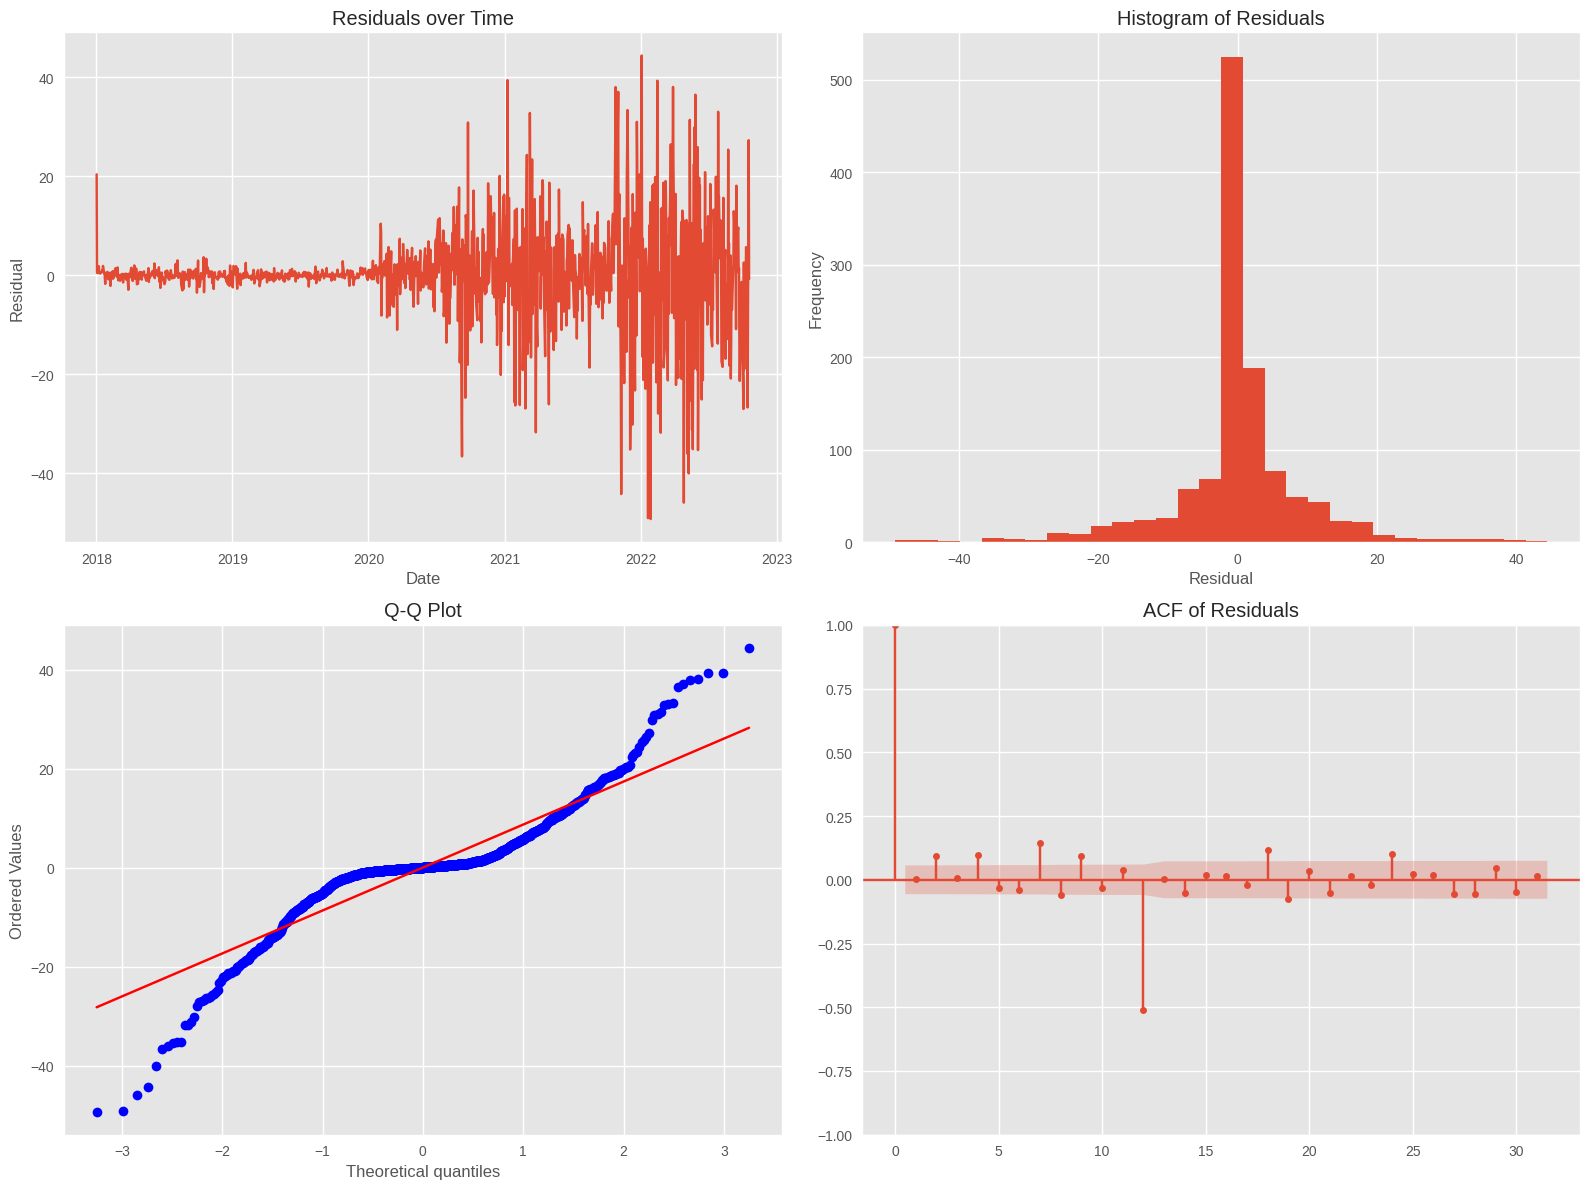

Ljung-Box test results:
       lb_stat     lb_pvalue
10   66.871400  1.774859e-10
20  418.945716  2.379339e-76
30  450.182419  1.838630e-76


In [ ]:
sarima_model.residual_diagnostics()

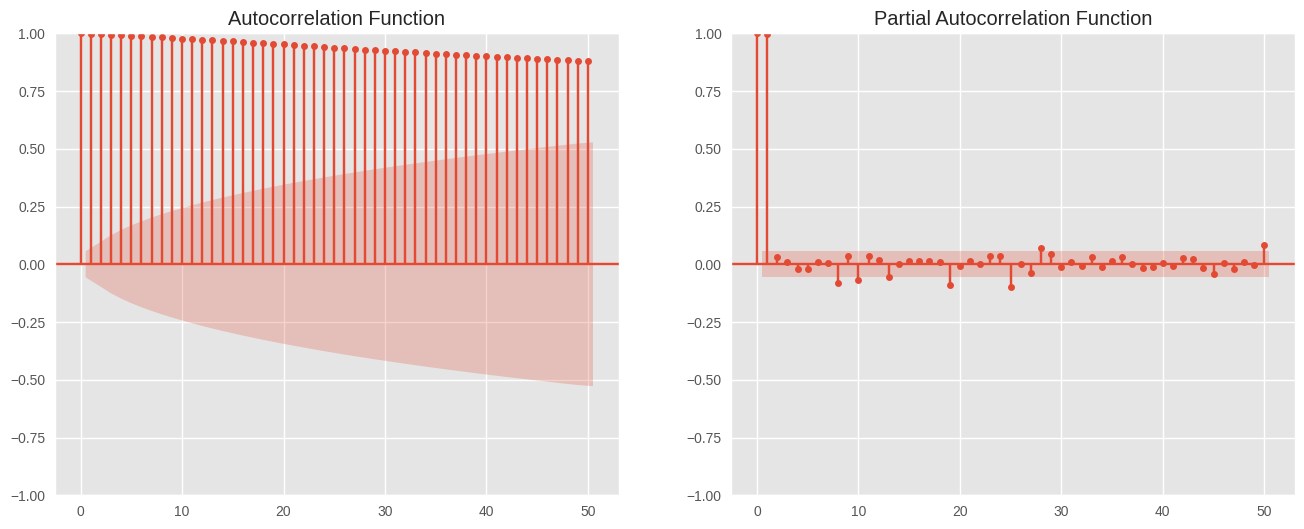

In [ ]:
sarima_model.plot_acf_pacf(lags=50)

# 5. Long Short-Term Memory (LSTM)

## 5.1 LSTM

In [ ]:
class LSTMModel:
    def __init__(self, train, test, target_column):
        """
        Initializes the LSTMModel with training and testing datasets.
        """
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column

        # Scale the data
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.train = self.scaler.fit_transform(train[[target_column]].values)
        self.test = self.scaler.transform(test[[target_column]].values)

        self.train_df = train
        self.test_df = test

        self.train_len = len(self.train)
        self.test_len = len(self.test)

        self.train_dates = train.index
        self.test_dates = test.index

        self.results_df = pd.DataFrame(columns=[
            'Number of Units in First Layer', 'Batch Size', 'Epochs', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R_Squared', 'Adj_R_Squared'
        ])
        self.best_model = None
        self.best_params = None
        self.model = None  # Ensure model attribute is initialized
        self.history = None  # To store training history
        self.predictions = None  # To store predictions for plotting

    def prepare_data(self, data, time_step=60):
        x, y = [], []
        for i in range(time_step, len(data)):
            x.append(data[i-time_step:i, 0])
            y.append(data[i, 0])
        return np.array(x), np.array(y)

    def build_model(self, units, input_shape):
        model = Sequential()
        model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.35))
        model.add(LSTM(units // 2, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model

    def calculate_metrics(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
        mase = mae / np.mean(np.abs(np.diff(y_true, axis=0)))

        # R-squared and Adjusted R-squared
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_res = np.sum((y_true - y_pred) ** 2)
        r_squared = 1 - (ss_res / ss_total)
        adj_r_squared = 1 - ((1 - r_squared) * (len(y_true) - 1) / (len(y_true) - y_true.shape[1] - 1))

        return mse, rmse, mae, mape, smape, mase, r_squared, adj_r_squared

    def fit_and_evaluate(self, units, batch_size, epochs):
        x_train, y_train = self.prepare_data(self.train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        model = self.build_model(units, (x_train.shape[1], 1))
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.2)

        self.history = history  # Save the training history for later plotting

        x_test, y_test = self.prepare_data(np.concatenate((self.train[-60:], self.test)))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        predictions = model.predict(x_test)
        predictions = self.scaler.inverse_transform(predictions)

        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate all metrics
        mse, rmse, mae, mape, smape, mase, r_squared, adj_r_squared = self.calculate_metrics(y_test, predictions)

        # Store results in DataFrame
        self.results_df = pd.concat([self.results_df, pd.DataFrame({
            'Number of Units in First Layer': [units],
            'Batch Size': [batch_size],
            'Epochs': [epochs],
            'MSE': [mse],
            'RMSE': [rmse],
            'MAE': [mae],
            'MAPE': [mape],
            'SMAPE': [smape],
            'MASE': [mase],
            'R_Squared': [r_squared],
            'Adj_R_Squared': [adj_r_squared]
        })], ignore_index=True)

        return model, mse

    def grid_search(self, units_list, batch_size_list, epochs_list):
        """
        Perform grid search over specified hyperparameters and store the performance metrics.
        """
        best_mse = float('inf')

        for units in units_list:
            for batch_size in batch_size_list:
                for epochs in epochs_list:
                    print(f"Evaluating LSTM with {units} units, batch size {batch_size}, and {epochs} epochs...")
                    model, mse = self.fit_and_evaluate(units, batch_size, epochs)

                    if mse < best_mse:
                        best_mse = mse
                        self.best_model = model
                        self.best_params = {
                            'Number of Units in First Layer': units,
                            'Batch Size': batch_size,
                            'Epochs': epochs
                        }
                        self.model = model  # Save the best model to self.model

        # Sort the results by MSE
        self.results_df.sort_values(by='MSE', ascending=True, inplace=True)
        print("\nTop 10 Model Configurations by MSE:")
        print(self.results_df.head(10))

        print("\nBest Model Parameters:")
        print(self.best_params)

        return self.results_df

    def predict_best_model(self):
        """
        Generates predictions using the best model found during grid search.
        """
        if self.best_model is None:
            raise ValueError("No best model found. Please run grid_search first.")

        x_test, y_test = self.prepare_data(np.concatenate((self.train[-60:], self.test)))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        self.predictions = self.best_model.predict(x_test)
        self.predictions = self.scaler.inverse_transform(self.predictions)

        return self.predictions

    def predict(self):
        """
         Functions for predict_best_model to be used for forecasting.
        """
        predictions = self.predict_best_model()
        return predictions

    def plot_training_metrics(self):
        """
        Plots the training loss, accuracy, and any other metrics stored during the training process.
        """
        if self.history is None:
            raise ValueError("No training history available. Ensure the model has been trained.")

        # Plot Loss
        plt.figure(figsize=(12, 6))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot Accuracy
        plt.figure(figsize=(12, 6))
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_results(self):
        """
        Plots the LSTM model's predictions alongside the actual training and testing data.
        """
        if self.predictions is None:
            raise ValueError("No predictions available. Ensure the model has made predictions.")

        train_values = self.train_df[self.target_column].values
        test_values = self.test_df[self.target_column].values

        pred_dates = self.test_df.index

        plt.figure(figsize=(12, 6))
        plt.plot(self.train_df.index, train_values, label='Train', color='#39304A', linestyle='-')
        plt.plot(pred_dates, test_values, label='Valid', color='#A98D75', linestyle='-')
        plt.plot(pred_dates, self.predictions.reshape(-1), label='Predictions', color='#FFAA00', linestyle='-')

        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.title('LSTM Model Results')
        plt.legend()
        plt.xticks(rotation=45)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.gcf().autofmt_xdate()

        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:

# Example usage:
lstm_model = LSTMModel(train, test, target_column='Close')

# Define hyperparameter grids

# Number of units in the first LSTM layer
units_list = [32, 64, 128]

# Batch sizes to try
batch_size_list = [16, 32, 64]

# Number of epochs to try
epochs_list = [10, 20, 50]

# Perform grid search and evaluate the model configurations
results_df = lstm_model.grid_search(units_list, batch_size_list, epochs_list)

# Display the top 10 results
results_df.head(10)


Evaluating LSTM with 32 units, batch size 16, and 10 epochs...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Evaluating LSTM with 32 units, batch size 16, and 20 epochs...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Evaluating LSTM with 32 units, batch size 16, and 50 epochs...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Evaluating LSTM with 32 units, batch size 32, and 10 epochs...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Evaluating LSTM with 32 units, batch size 32, and 20 epochs...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Evaluating LSTM with 32 units, batch size 32, and 50 epochs...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Evaluating LSTM with 32 units, batch size 64, and 10 epochs...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Evaluating LSTM with 32 units, batch size 64, and 20 epochs...
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
Evaluating LSTM with 32 units, batch size 64, and 50 epochs...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Evaluating LSTM with 64 units, batch size 16, and 10 epochs...
10/10 ━━━

Number of Units in First Layer Batch Size Epochs         MSE        MAE  \
11                             64         16     50   94.319801   7.620868   
23                            128         32     50  110.041364   8.271569   
20                            128         16     50  119.102921   8.858033   
26                            128         64     50  129.866432   8.946494   
22                            128         32     20  161.763317  10.000391   
18                            128         16     10  171.423646  10.628703   
25                            128         64     20  235.162981  12.150467   
19                            128         16     20  250.352395  13.265607   
14                             64         32     50  273.862816  13.637124   
21                            128         32     10  284.196303  13.370860   

         RMSE      MAPE     SMAPE      MASE  R_Squared  Adj_R_Squared  
11   9.711838  3.805122  3.765173  1.396061   0.947946       0.947773  
23  10.490060  4.043379  4.047628  1.515262   0.939270       0.939067  
20  10.913428  4.189306  4.258866  1.622696   0.934269       0.934050  
26  11.395895  4.433729  4.401023  1.638901   0.928329       0.928090  
22  12.718621  5.028393  4.954024  1.831963   0.910725       0.910428  
18  13.092885  5.179989  5.239151  1.947063   0.905394       0.905079  
25  15.335025  6.286507  6.014736  2.225834   0.870217       0.869785  
19  15.822528  6.139721  6.347319  2.430116   0.861834       0.861374  
14  16.548801  6.325320  6.495819  2.498174   0.848859       0.848356  
21  16.858123  6.941236  6.635677  2.449397   0.843156       0.842634

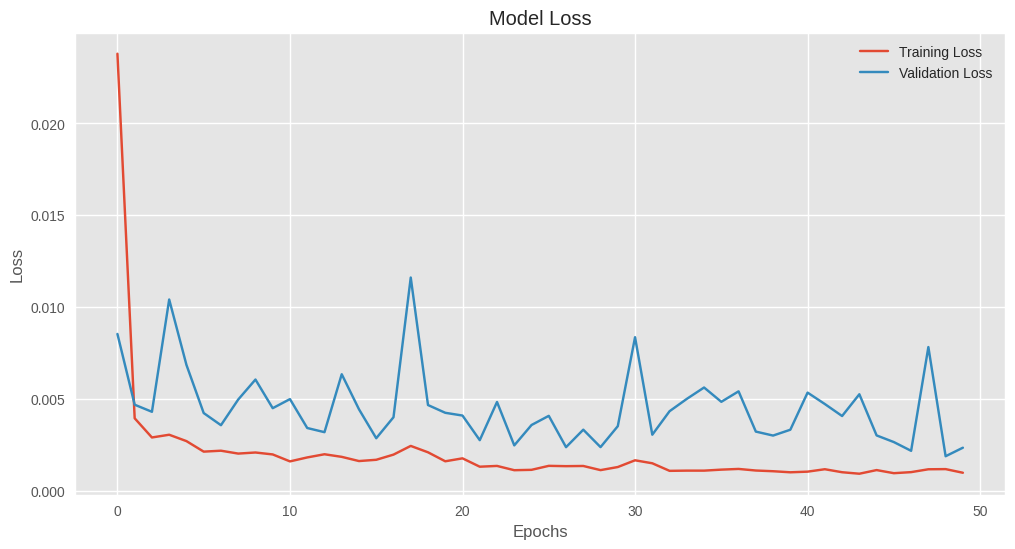

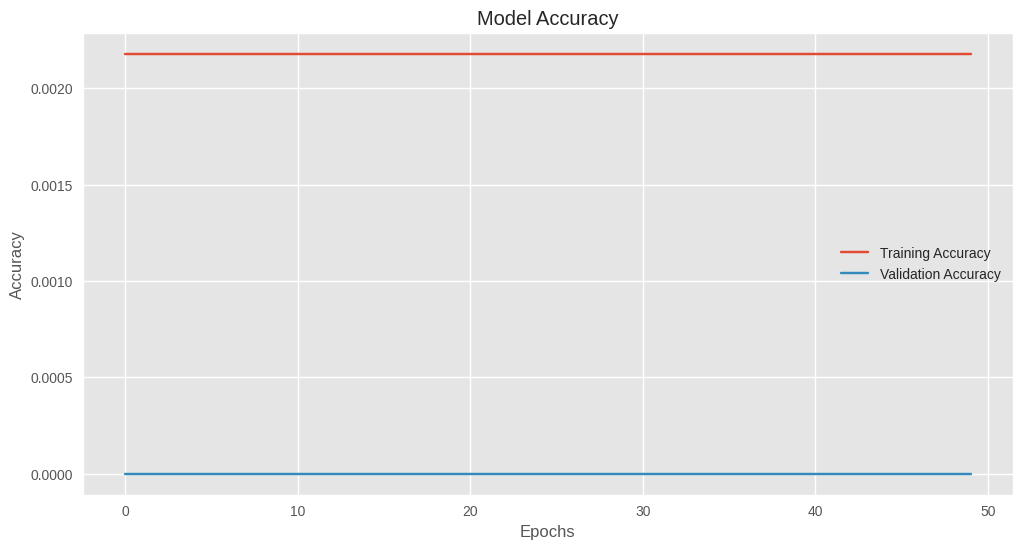

In [ ]:
# Plot the training metrics for the best model
lstm_model.plot_training_metrics()

In [ ]:
# After fitting the model and generating predictions:
lstm_model.predict()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[216.88571 ],
       [219.12961 ],
       [221.47173 ],
       [219.81082 ],
       [218.02345 ],
       [215.799   ],
       [216.44954 ],
       [219.01202 ],
       [222.11227 ],
       [225.5462  ],
       [228.05725 ],
       [229.48463 ],
       [226.9371  ],
       [222.96227 ],
       [217.36992 ],
       [209.93848 ],
       [202.05795 ],
       [192.81253 ],
       [187.99414 ],
       [187.95633 ],
       [189.4993  ],
       [192.40213 ],
       [193.65659 ],
       [192.84006 ],
       [190.37975 ],
       [184.64496 ],
       [178.83032 ],
       [177.41838 ],
       [178.70757 ],
       [181.2454  ],
       [183.40167 ],
       [188.11298 ],
       [193.0949  ],
       [196.76405 ],
       [196.25151 ],
       [192.98518 ],
       [187.48907 ],
       [181.79343 ],
       [178.71317 ],
       [175.21812 ],
       [170.76158 ],
       [165.86284 ],
       [162.03877 ],
       [157.99336 ],
       [154.65741 ],
       [149.7413  ],
       [144.9737  ],
       [138.6

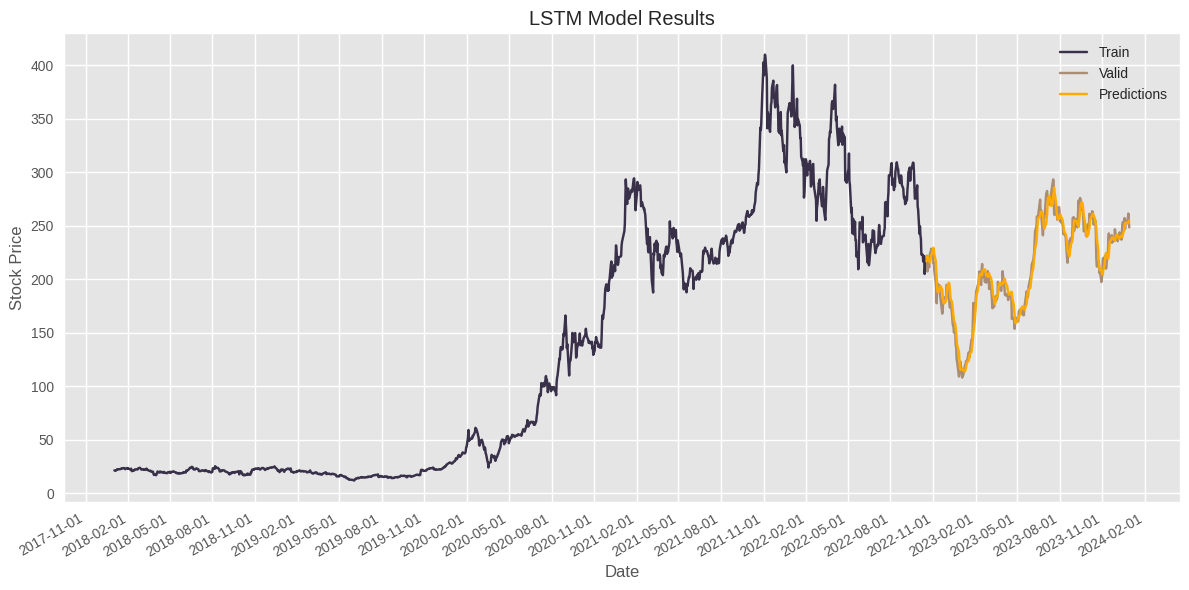

In [ ]:
lstm_model.plot_results()

# Comparison

## Compare forecasts

In [ ]:
def compare_forecasts_and_plot(arima_model, arimax_model, sarima_model, lstm_model, train, test):
    """
    Compare forecasts from ARIMA, ARIMAX, SARIMA, and LSTM models, and plot the results.

    Parameters:
    arima_model: Trained ARIMA model object.
    arimax_model: Trained ARIMAX model object.
    sarima_model: Trained SARIMA model object.
    lstm_model: Trained LSTM model object.
    train (pd.DataFrame): Training dataset with a DateTime index.
    test (pd.DataFrame): Testing dataset with a DateTime index.
    """

    # Generate forecasts using each model
    arima_model.make_forecast()
    arimax_model.make_forecast()
    sarima_model.make_forecast()

    # Assuming lstm_model.predict() returns the forecast for the entire dataset
    lstm_forecast = lstm_model.predict()

    # Adjust LSTM forecast to match the length of the test set
    lstm_forecast = lstm_forecast[-len(test):]  # Take the last N predictions where N is the length of the test set

    # Access the forecasts directly (assuming they are Pandas Series or 1D arrays)
    arima_forecast = arima_model.forecast
    arimax_forecast = arimax_model.forecast
    sarima_forecast = sarima_model.forecast

    # Extract the date index for the test set
    dates = test.index

    # Ensure the forecast arrays have the same length as the test set
    if len(dates) != len(arima_forecast):
        raise ValueError(f"Mismatch between dates length ({len(dates)}) and ARIMA forecast length ({len(arima_forecast)})")
    if len(dates) != len(arimax_forecast):
        raise ValueError(f"Mismatch between dates length ({len(dates)}) and ARIMAX forecast length ({len(arimax_forecast)})")
    if len(dates) != len(sarima_forecast):
        raise ValueError(f"Mismatch between dates length ({len(dates)}) and SARIMA forecast length ({len(sarima_forecast)})")
    if len(dates) != len(lstm_forecast):
        raise ValueError(f"Mismatch between dates length ({len(dates)}) and LSTM forecast length ({len(lstm_forecast)})")

    # Plot the forecasts along with the actual test data
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train.index, train[arima_model.target_column], label='Training Data', color='blue')

    # Plot actual test data
    plt.plot(dates, test[arima_model.target_column], label='Actual Data', color='black')

    # Plot ARIMA forecast
    plt.plot(dates, arima_forecast, label=f'ARIMA Forecast (Order: {arima_model.get_best_order()})')

    # Plot ARIMAX forecast
    plt.plot(dates, arimax_forecast, label=f'ARIMAX Forecast (Order: {arimax_model.get_best_order()})')

    # Plot SARIMA forecast
    plt.plot(dates, sarima_forecast, label=f'SARIMA Forecast (Order: {sarima_model.get_best_order()})')

    # Plot LSTM forecast
    plt.plot(dates, lstm_forecast, label='LSTM Forecast', color='magenta')

    # Add title and labels
    plt.title('Model Comparison: ARIMA, ARIMAX, SARIMA, and LSTM Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


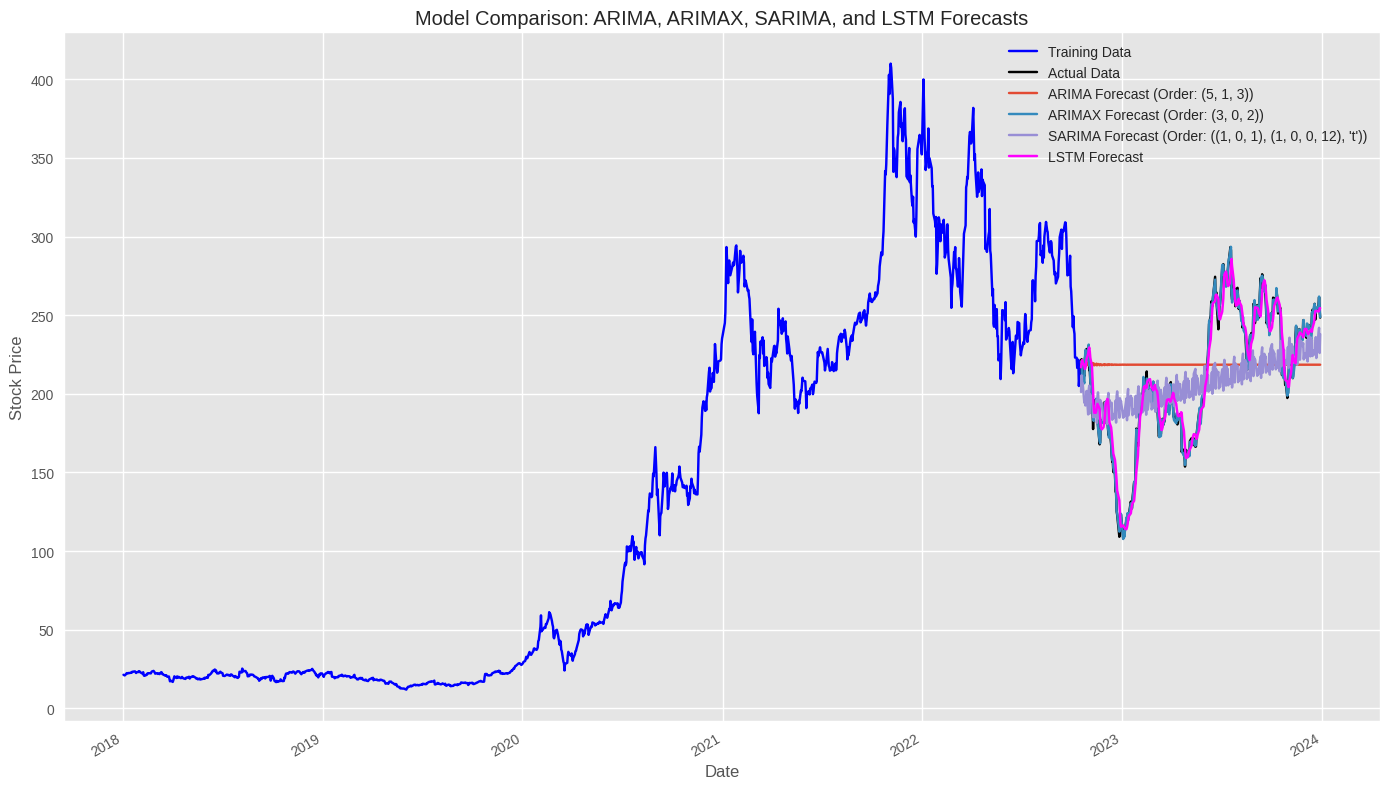

In [ ]:
compare_forecasts_and_plot(arima_model, arimax_model, sarima_model, lstm_model, train, test)

In [ ]:
def compare_plot_accuracy(arima_model, arimax_model, sarima_model, lstm_model, test):
    """
    Compare forecasts from ARIMA, ARIMAX, SARIMA, and LSTM models, and plot the results focusing on the forecast and test data.

    Parameters:
    arima_model: Trained ARIMA model object.
    arimax_model: Trained ARIMAX model object.
    sarima_model: Trained SARIMA model object.
    lstm_model: Trained LSTM model object.
    train (pd.DataFrame): Training dataset with a DateTime index.
    test (pd.DataFrame): Testing dataset with a DateTime index.
    """

    # Generate forecasts using each model
    arima_model.make_forecast()
    arimax_model.make_forecast()
    sarima_model.make_forecast()
    lstm_forecast = lstm_model.predict()

    # Adjust LSTM forecast to match the length of the test set
    lstm_forecast = lstm_forecast[-len(test):]

    # Access the forecasts directly (assuming they are Pandas Series or 1D arrays)
    arima_forecast = arima_model.forecast
    arimax_forecast = arimax_model.forecast
    sarima_forecast = sarima_model.forecast

    # Extract the date index for the test set
    dates = test.index

    # Ensure the forecast arrays have the same length as the test set
    if len(dates) != len(arima_forecast):
        raise ValueError(f"Mismatch between dates length ({len(dates)}) and ARIMA forecast length ({len(arima_forecast)})")
    if len(dates) != len(arimax_forecast):
        raise ValueError(f"Mismatch between dates length ({len(dates)}) and ARIMAX forecast length ({len(arimax_forecast)})")
    if len(dates) != len(sarima_forecast):
        raise ValueError(f"Mismatch between dates length ({len(dates)}) and SARIMA forecast length ({len(sarima_forecast)})")
    if len(dates) != len(lstm_forecast):
        raise ValueError(f"Mismatch between dates length ({len(dates)}) and LSTM forecast length ({len(lstm_forecast)})")

    # Plot the forecasts along with the actual test data, focusing on the test period
    plt.figure(figsize=(14, 8))

    # Plot actual test data
    plt.plot(dates, test[arima_model.target_column], label='Actual Data', color='black')

    # Plot ARIMA forecast
    plt.plot(dates, arima_forecast, label=f'ARIMA Forecast (Order: {arima_model.get_best_order()})')

    # Plot ARIMAX forecast
    plt.plot(dates, arimax_forecast, label=f'ARIMAX Forecast (Order: {arimax_model.get_best_order()})')

    # Plot SARIMA forecast
    plt.plot(dates, sarima_forecast, label=f'SARIMA Forecast (Order: {sarima_model.get_best_order()})')

    # Plot LSTM forecast
    plt.plot(dates, lstm_forecast, label='LSTM Forecast', color='magenta')

    # Add title and labels
    plt.title('Model Comparison: ARIMA, ARIMAX, SARIMA, and LSTM Forecasts (Test Period)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


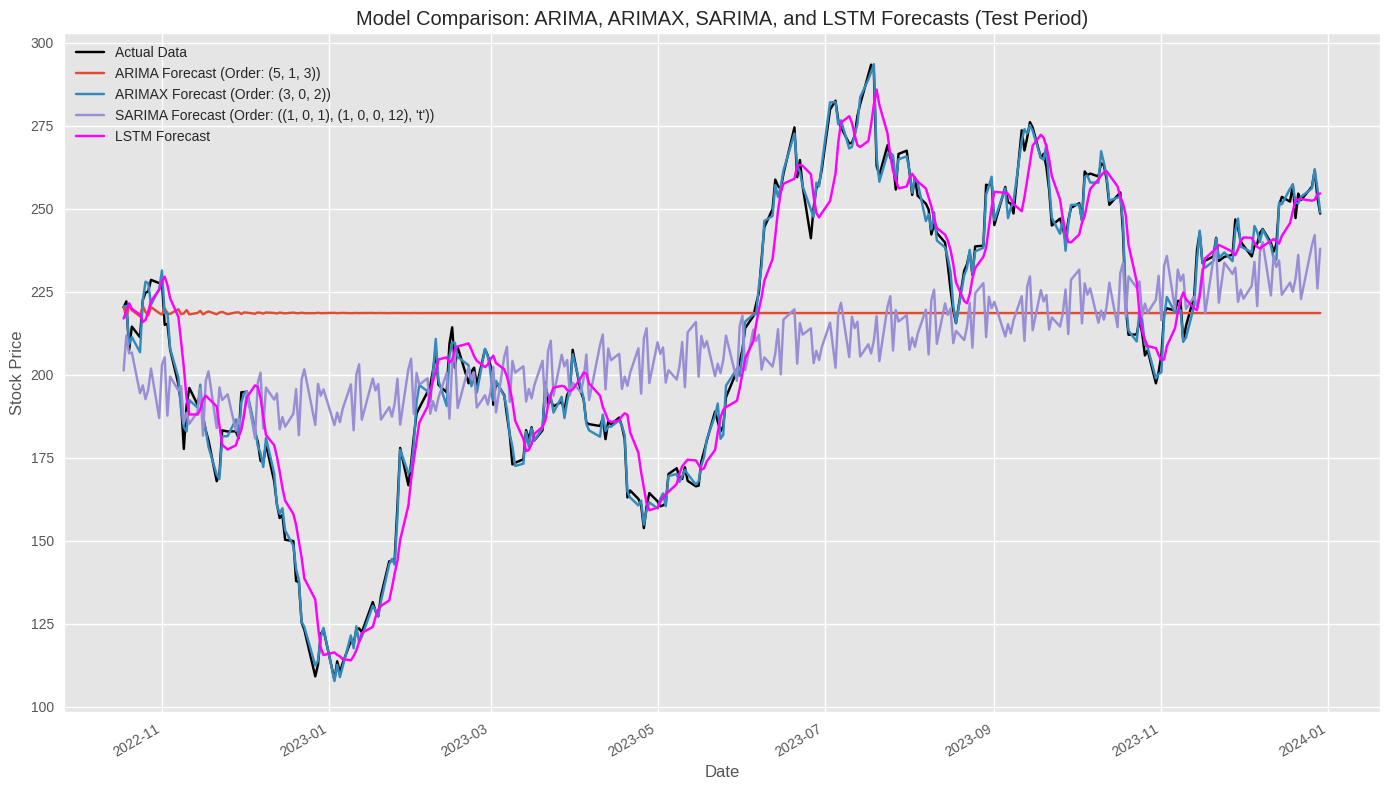

In [ ]:
compare_plot_accuracy(arima_model, arimax_model, sarima_model, lstm_model, test)

## Evaluate Models

In [ ]:
def combine_model_metrics(arima_df, arimax_df, afrima_df, lstm_metrics_df):
    """
    Combines the top metrics from ARIMA, ARIMAX, SARIMA models, and the best LSTM model into a single DataFrame.
    The ARIMA-based models include the order (p, d, q) in the model name.
    The final DataFrame is sorted in ascending order by the MSE column.

    Parameters:
    arima_df (pd.DataFrame): DataFrame from the ARIMA model's display_top_orders function.
    arimax_df (pd.DataFrame): DataFrame from the ARIMAX model's display_top_orders function.
    afrima_df (pd.DataFrame): DataFrame from the SARIMA model's display_top_orders function.
    lstm_metrics_df (pd.DataFrame): DataFrame from the LSTM model's evaluate_model function.

    Returns:
    pd.DataFrame: A combined and sorted DataFrame with the top metrics from each model.
    """

    # Ensure the DataFrames are not None
    if arima_df is None or arimax_df is None or afrima_df is None or lstm_metrics_df is None:
        raise ValueError("One or more model DataFrames are None. Please check the model outputs.")

    # Select the top (best) order from each ARIMA-based model DataFrame
    top_arima = arima_df.sort_values(by='MSE').iloc[0:1].copy()
    top_arimax = arimax_df.sort_values(by='MSE').iloc[0:1].copy()
    top_afrima = afrima_df.sort_values(by='MSE').iloc[0:1].copy()

    # Extract the order (p, d, q) for each model and update the Model column
    top_arima['Model'] = top_arima.apply(lambda row: f"ARIMA{row['Order']}", axis=1)
    top_arimax['Model'] = top_arimax.apply(lambda row: f"ARIMAX{row['Order']}", axis=1)
    top_afrima['Model'] = top_afrima.apply(lambda row: f"SARIMA{row['Order']}", axis=1)

    # Select the LSTM model with the lowest MSE
    best_lstm = lstm_metrics_df.sort_values(by='MSE').iloc[0:1].copy()
    best_lstm['Model'] = 'LSTM'

    # Select and reorder columns for consistency
    cols_order = ['Model', 'MSE', 'MAE', 'RMSE', 'R_Squared', 'Adj_R_Squared']

    top_arima = top_arima[cols_order]
    top_arimax = top_arimax[cols_order]
    top_afrima = top_afrima[cols_order]
    best_lstm = best_lstm[cols_order]

    # Combine the DataFrames
    combined_df = pd.concat([top_arima, top_arimax, top_afrima, best_lstm], ignore_index=True)

    # Sort the combined DataFrame by MSE in ascending order
    combined_df = combined_df.sort_values(by='MSE', ascending=True)

    # Return the sorted combined DataFrame
    return combined_df


In [ ]:
arima_df = arima_model.display_top_orders()
arimax_df = arimax_model.display_top_orders()
sarima_df = sarima_model.display_top_orders()

Top 5 ARIMAX model orders with the lowest MSE:
       Order          MSE        MAE       RMSE  MAPE  SMAPE  MASE  R_Squared  \
0  (1, 0, 1)  1239.214222  28.231810  35.202475   NaN    NaN   NaN   0.316097   
1  (1, 0, 0)  1295.694281  29.037150  35.995754   NaN    NaN   NaN   0.284926   
2  (1, 0, 1)  1335.590120  29.515630  36.545726   NaN    NaN   NaN   0.262908   
3  (1, 0, 0)  1361.323913  29.798140  36.896123   NaN    NaN   NaN   0.248706   
4  (1, 0, 1)  1375.586619  30.083464  37.088902   NaN    NaN   NaN   0.240835   

   Adj_R_Squared          AIC          BIC  
0       0.309212  8916.725620  8942.209227  
1       0.277728  8918.432115  8943.915722  
2       0.255488  8772.869944  8793.216896  
3       0.241143  8771.012842  8786.273056  
4       0.233192  8772.705974  8793.052925  


In [ ]:
combined_metrics_df = combine_model_metrics(arima_df, arimax_df, sarima_df, lstm_model.results_df)
display(combined_metrics_df.style.hide(axis="index"))